# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.2 MB/s eta 0:13:46tcmalloc: large alloc 1147494400 bytes == 0x39e2c000 @  0x7f9b3d2bf615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.1 MB/s eta 0:11:26tcmalloc: large alloc 1434370048 bytes == 0x7e482000 @  0x7f9b3d2bf615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████████████▎        | 

In [4]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12947, done.
remote: Total 12947 (delta 0), reused 0 (delta 0), pack-reused 12947
Receiving objects: 100% (12947/12947), 15.13 MiB | 9.70 MiB/s, done.
Resolving deltas: 100% (9359/9359), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 648 kB 4.3 MB/s 
  Running setup.py develop for mmsegmentation


In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.1


## Upload data from drive

In [6]:
!mkdir checkpoints

from google.colab import drive
import os
from os import path
import shutil

drive.mount('/content/drive')

## Change the directories to reflect where your data is located
%cp -av "/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet"  "/content/mmsegmentation/data_NRCan2022_hrnet"
%cp -av "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet"  "/content/mmsegmentation/checkpoints"

# Update the class_names.py file to get a palette with two colours (poles-yellow, background-purple)
%rm "/content/mmsegmentation/mmseg/core/evaluation/class_names.py"
%cp -av "/content/drive/MyDrive/NRCan2022/class_names.py"  "/content/mmsegmentation/mmseg/core/evaluation/class_names.py"

Streaming output truncated to the last 5000 lines.
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.604838596_lon_-74.5879173214_hdg_198.454023361.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.604838596_lon_-74.5879173214_hdg_198.454023361.png'
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.5673192301_lon_-75.1206635494_hdg_457.514831543.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.5673192301_lon_-75.1206635494_hdg_457.514831543.png'
'/content/drive/MyDrive/NRCan2022/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.6338932486_lon_-77.4772583605_hdg_483.555244446.png' -> '/content/mmsegmentation/data_NRCan2022_hrnet/poles/yasmina_data/ann_dir/train/img_ref_0_stp_1_lat_45.6338932486_lon_-77.4772583605_hdg_483.

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix.

Ensure that the dataset is subdivided into train/val/test data.

In [7]:
!mkdir data
!mkdir data/images
!mkdir data/labels

%cp -av "/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train"  "/content/mmsegmentation/data/images/test"
%cp -av "/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/ann_dir/train"  "/content/mmsegmentation/data/labels/test"

%cp -av "/content/mmsegmentation/data_NRCan2022_hrnet/poles/waterloo/img_dir/train"  "/content/mmsegmentation/data/images/train"
%cp -av "/content/mmsegmentation/data_NRCan2022_hrnet/poles/waterloo/ann_dir/train"  "/content/mmsegmentation/data/labels/train"


'/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train' -> '/content/mmsegmentation/data/images/test'
'/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7416765928_lon_-68.5092712499_hdg_520.936828613.jpg' -> '/content/mmsegmentation/data/images/test/img_ref_0_stp_1_lat_63.7416765928_lon_-68.5092712499_hdg_520.936828613.jpg'
'/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.742532673_lon_-68.4895670163_hdg_256.325668335.jpg' -> '/content/mmsegmentation/data/images/test/img_ref_0_stp_1_lat_63.742532673_lon_-68.4895670163_hdg_256.325668335.jpg'
'/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7403780749_lon_-68.5050179495_hdg_330.751794815.jpg' -> '/content/mmsegmentation/data/images/test/img_ref_0_stp_1_lat_63.7403780749_lon_-68.5050179495_hdg_330.751794815.jpg'
'/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/

We need to convert the annotation into semantic map format as an image.

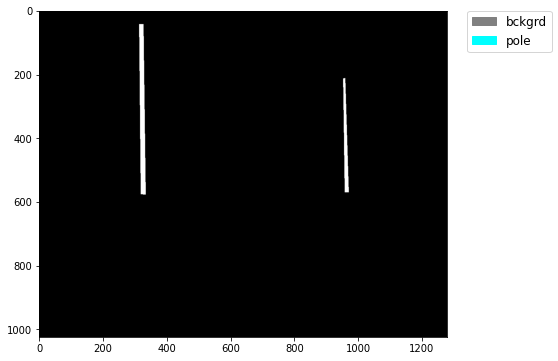

In [9]:
# Let's take a look at the segmentation map we got
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#img = Image.open('/content/mmsegmentation/data/labels/test/img_ref_0_stp_1_lat_63.764032475_lon_-68.5303999476_hdg_515.449310303.png')
img = Image.open('/content/mmsegmentation/data/labels/train/2018_03_06_0001_image_02_0000000071.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# define class and plaette for better visualization
classes = ('bckgrd','pole')
palette = [[128, 128, 128],[0,255,255]]


# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 21 22:42:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [55]:
# create test txt list
import os.path as osp
import mmcv
import random

data_root = 'data'
img_dir_train = 'images/train'
ann_dir_train = 'labels/train'
#img_dir_test = 'images/test'
#ann_dir_test = 'labels/test'

filename_list_train = []
filename_list_val_test = []
filename_list_val = []
filename_list_test = []

split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))

filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir_train), suffix='.png')]

filename_list.sort()

rsample = random.sample(range(0, len(filename_list)), 1)

for i in range(0, len(filename_list)):
  if i in rsample:
    filename_list_val.append(filename_list[i])
  else:
    filename_list_train.append(filename_list[i])

#filename_list_test = filename_list[166:]
#filename_list_val = filename_list[133:166]
#filename_list_train = filename_list[0:133]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list_train)

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list_val)

#with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
#  f.writelines(line + '\n' for line in filename_list_test)

print('Train:', len(filename_list_train))
print('Val:', len(filename_list_val))
print('Test:', len(filename_list_test))

print('Total: ', len(filename_list_train)+len(filename_list_val)+len(filename_list_test))
print(len(filename_list))

Train: 207
Val: 1
Test: 0
Total:  208
208


After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [18]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [58]:
import os.path as osp
import mmcv

data_root = 'data'
img_dir_train = 'images/train'
ann_dir_train = 'labels/train'
img_dir_test = 'images/train'
ann_dir_test = 'labels/train'

In [59]:
from mmcv import Config
# cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

cfg = Config.fromfile('configs/hrnet/fcn_hr48_512x1024_160k_cityscapes.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [61]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
# cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir_train
cfg.data.train.ann_dir = ann_dir_train
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir_train
cfg.data.val.ann_dir = ann_dir_train
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

#cfg.data.test.type = cfg.dataset_type
#cfg.data.test.data_root = cfg.data_root
#cfg.data.test.img_dir = img_dir_train
#cfg.data.test.ann_dir = ann_dir_train
#cfg.data.test.pipeline = cfg.test_pipeline
#cfg.data.test.split = 'splits/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.load_from = 'checkpoints/model_checkpoint_finetuned_poles_hrnet/fcn_hr48_512x1024_160k_cityscapes_20200602_190946-59b7973e.pth'
#cfg.load_from = 'checkpoints/model_checkpoint_finetuned_poles_hrnet/poles_hrnet_ocr_iter_4000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 4000
cfg.log_config.interval = 50
cfg.evaluation.interval = 50
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://msra/hrnetv2_w48',
    backbone=dict(
        type='HRNet',
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(48, 96)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(48, 96, 192)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
                block='BASIC',
     

### Train and Evaluation

In [62]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import time


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

start = time.time()

train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

print('Traning Time:', time.time() - start)

2022-12-22 01:01:33,467 - mmseg - INFO - Loaded 207 images
2022-12-22 01:01:34,172 - mmseg - INFO - Loaded 1 images
2022-12-22 01:01:34,173 - mmseg - INFO - load checkpoint from local path: checkpoints/model_checkpoint_finetuned_poles_hrnet/fcn_hr48_512x1024_160k_cityscapes_20200602_190946-59b7973e.pth
2022-12-22 01:01:35,879 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 720, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 720, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-12-22 01:01:35,889 - mmseg - INFO - Start running, host: root@c07ded8bf189, work_dir: /content/mmsegmentation/work_dirs/tutorial
2022-12-22 01:01:35,891 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 1.3 task/s, elapsed: 1s, ETA:     0s

2022-12-22 01:02:04,296 - mmseg - INFO - per class results:
2022-12-22 01:02:04,298 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.39 | 100.0 |
|  pole  |  0.35 |  0.35 |
+--------+-------+-------+
2022-12-22 01:02:04,301 - mmseg - INFO - Summary:
2022-12-22 01:02:04,302 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.39 | 49.87 | 50.18 |
+-------+-------+-------+
2022-12-22 01:02:04,304 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9939, mIoU: 0.4987, mAcc: 0.5018, IoU.bckgrd: 0.9939, IoU.pole: 0.0035, Acc.bckgrd: 1.0000, Acc.pole: 0.0035
2022-12-22 01:02:32,051 - mmseg - INFO - Iter [100/4000]	lr: 9.779e-03, eta: 0:36:10, time: 0.571, data_time: 0.122, memory: 4149, decode.loss_ce: 0.0247, decode.acc_seg: 98.9148, loss: 0.0247


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:02:32,204 - mmseg - INFO - per class results:
2022-12-22 01:02:32,206 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.46 | 99.91 |
|  pole  | 23.15 | 26.48 |
+--------+-------+-------+
2022-12-22 01:02:32,208 - mmseg - INFO - Summary:
2022-12-22 01:02:32,210 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.46 | 61.31 | 63.2 |
+-------+-------+------+
2022-12-22 01:02:32,211 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9946, mIoU: 0.6131, mAcc: 0.6320, IoU.bckgrd: 0.9946, IoU.pole: 0.2315, Acc.bckgrd: 0.9991, Acc.pole: 0.2648
2022-12-22 01:03:00,085 - mmseg - INFO - Iter [150/4000]	lr: 9.667e-03, eta: 0:35:47, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0204, decode.acc_seg: 99.1015, loss: 0.0204


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:03:00,232 - mmseg - INFO - per class results:
2022-12-22 01:03:00,233 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.45 | 99.94 |
|  pole  | 17.41 | 18.98 |
+--------+-------+-------+
2022-12-22 01:03:00,235 - mmseg - INFO - Summary:
2022-12-22 01:03:00,238 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.45 | 58.43 | 59.46 |
+-------+-------+-------+
2022-12-22 01:03:00,239 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9945, mIoU: 0.5843, mAcc: 0.5946, IoU.bckgrd: 0.9945, IoU.pole: 0.1741, Acc.bckgrd: 0.9994, Acc.pole: 0.1898
2022-12-22 01:03:28,456 - mmseg - INFO - Saving checkpoint at 200 iterations
2022-12-22 01:03:31,818 - mmseg - INFO - Iter [200/4000]	lr: 9.556e-03, eta: 0:36:32, time: 0.635, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0208, decode.acc_seg: 99.0882, loss: 0.0208


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:03:31,988 - mmseg - INFO - per class results:
2022-12-22 01:03:31,990 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.44 | 99.98 |
|  pole  | 11.82 | 12.28 |
+--------+-------+-------+
2022-12-22 01:03:31,992 - mmseg - INFO - Summary:
2022-12-22 01:03:31,993 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.44 | 55.63 | 56.13 |
+-------+-------+-------+
2022-12-22 01:03:31,995 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9944, mIoU: 0.5563, mAcc: 0.5613, IoU.bckgrd: 0.9944, IoU.pole: 0.1182, Acc.bckgrd: 0.9998, Acc.pole: 0.1228
2022-12-22 01:03:59,909 - mmseg - INFO - Iter [250/4000]	lr: 9.444e-03, eta: 0:35:52, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0191, decode.acc_seg: 99.1458, loss: 0.0191


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:04:00,054 - mmseg - INFO - per class results:
2022-12-22 01:04:00,056 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.46 | 99.99 |
|  pole  | 14.23 | 14.56 |
+--------+-------+-------+
2022-12-22 01:04:00,057 - mmseg - INFO - Summary:
2022-12-22 01:04:00,060 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 56.85 | 57.27 |
+-------+-------+-------+
2022-12-22 01:04:00,061 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5685, mAcc: 0.5727, IoU.bckgrd: 0.9946, IoU.pole: 0.1423, Acc.bckgrd: 0.9999, Acc.pole: 0.1456
2022-12-22 01:04:28,195 - mmseg - INFO - Iter [300/4000]	lr: 9.331e-03, eta: 0:35:18, time: 0.566, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0184, decode.acc_seg: 99.1726, loss: 0.0184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:04:28,345 - mmseg - INFO - per class results:
2022-12-22 01:04:28,346 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.47 | 99.98 |
|  pole  |  14.9 | 15.29 |
+--------+-------+-------+
2022-12-22 01:04:28,347 - mmseg - INFO - Summary:
2022-12-22 01:04:28,349 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 57.19 | 57.64 |
+-------+-------+-------+
2022-12-22 01:04:28,350 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5719, mAcc: 0.5764, IoU.bckgrd: 0.9947, IoU.pole: 0.1490, Acc.bckgrd: 0.9998, Acc.pole: 0.1529
2022-12-22 01:04:56,264 - mmseg - INFO - Iter [350/4000]	lr: 9.219e-03, eta: 0:34:44, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0183, decode.acc_seg: 99.1572, loss: 0.0183


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:04:56,409 - mmseg - INFO - per class results:
2022-12-22 01:04:56,411 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.4 | 99.91 |
|  pole  | 13.64 | 15.59 |
+--------+-------+-------+
2022-12-22 01:04:56,412 - mmseg - INFO - Summary:
2022-12-22 01:04:56,414 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.4 | 56.52 | 57.75 |
+------+-------+-------+
2022-12-22 01:04:56,416 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9940, mIoU: 0.5652, mAcc: 0.5775, IoU.bckgrd: 0.9940, IoU.pole: 0.1364, Acc.bckgrd: 0.9991, Acc.pole: 0.1559
2022-12-22 01:05:24,387 - mmseg - INFO - Saving checkpoint at 400 iterations
2022-12-22 01:05:26,482 - mmseg - INFO - Iter [400/4000]	lr: 9.107e-03, eta: 0:34:30, time: 0.604, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0184, decode.acc_seg: 99.1535, loss: 0.0184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:05:26,651 - mmseg - INFO - per class results:
2022-12-22 01:05:26,652 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.47 | 99.97 |
|  pole  | 16.96 | 17.66 |
+--------+-------+-------+
2022-12-22 01:05:26,653 - mmseg - INFO - Summary:
2022-12-22 01:05:26,657 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 58.21 | 58.82 |
+-------+-------+-------+
2022-12-22 01:05:26,658 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5821, mAcc: 0.5882, IoU.bckgrd: 0.9947, IoU.pole: 0.1696, Acc.bckgrd: 0.9997, Acc.pole: 0.1766
2022-12-22 01:05:54,625 - mmseg - INFO - Iter [450/4000]	lr: 8.994e-03, eta: 0:33:57, time: 0.563, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0184, decode.acc_seg: 99.1342, loss: 0.0184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:05:54,772 - mmseg - INFO - per class results:
2022-12-22 01:05:54,774 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.91 |
|  pole  |  32.3 | 36.88 |
+--------+-------+-------+
2022-12-22 01:05:54,777 - mmseg - INFO - Summary:
2022-12-22 01:05:54,778 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.53 | 65.92 | 68.4 |
+-------+-------+------+
2022-12-22 01:05:54,780 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6592, mAcc: 0.6840, IoU.bckgrd: 0.9953, IoU.pole: 0.3230, Acc.bckgrd: 0.9991, Acc.pole: 0.3688
2022-12-22 01:06:22,710 - mmseg - INFO - Iter [500/4000]	lr: 8.881e-03, eta: 0:33:24, time: 0.562, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0178, decode.acc_seg: 99.1819, loss: 0.0178


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:06:22,858 - mmseg - INFO - per class results:
2022-12-22 01:06:22,859 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.89 |
|  pole  | 35.74 | 42.16 |
+--------+-------+-------+
2022-12-22 01:06:22,861 - mmseg - INFO - Summary:
2022-12-22 01:06:22,862 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 67.64 | 71.03 |
+-------+-------+-------+
2022-12-22 01:06:22,865 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6764, mAcc: 0.7103, IoU.bckgrd: 0.9954, IoU.pole: 0.3574, Acc.bckgrd: 0.9989, Acc.pole: 0.4216
2022-12-22 01:06:50,843 - mmseg - INFO - Iter [550/4000]	lr: 8.768e-03, eta: 0:32:52, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0183, decode.acc_seg: 99.1603, loss: 0.0183


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:06:50,982 - mmseg - INFO - per class results:
2022-12-22 01:06:50,984 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.96 |
|  pole  | 20.86 | 22.31 |
+--------+-------+-------+
2022-12-22 01:06:50,987 - mmseg - INFO - Summary:
2022-12-22 01:06:50,988 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.48 | 60.17 | 61.14 |
+-------+-------+-------+
2022-12-22 01:06:50,990 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6017, mAcc: 0.6114, IoU.bckgrd: 0.9948, IoU.pole: 0.2086, Acc.bckgrd: 0.9996, Acc.pole: 0.2231
2022-12-22 01:07:18,868 - mmseg - INFO - Saving checkpoint at 600 iterations
2022-12-22 01:07:20,834 - mmseg - INFO - Iter [600/4000]	lr: 8.655e-03, eta: 0:32:31, time: 0.600, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0173, decode.acc_seg: 99.1716, loss: 0.0173


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:07:21,004 - mmseg - INFO - per class results:
2022-12-22 01:07:21,006 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.89 |
|  pole  | 36.42 | 43.16 |
+--------+-------+-------+
2022-12-22 01:07:21,007 - mmseg - INFO - Summary:
2022-12-22 01:07:21,010 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 67.98 | 71.52 |
+-------+-------+-------+
2022-12-22 01:07:21,013 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6798, mAcc: 0.7152, IoU.bckgrd: 0.9954, IoU.pole: 0.3642, Acc.bckgrd: 0.9989, Acc.pole: 0.4316
2022-12-22 01:07:48,981 - mmseg - INFO - Iter [650/4000]	lr: 8.542e-03, eta: 0:32:00, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0171, decode.acc_seg: 99.1942, loss: 0.0171


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:07:49,127 - mmseg - INFO - per class results:
2022-12-22 01:07:49,129 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.95 |
|  pole  | 26.44 | 28.79 |
+--------+-------+-------+
2022-12-22 01:07:49,131 - mmseg - INFO - Summary:
2022-12-22 01:07:49,134 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 62.98 | 64.37 |
+-------+-------+-------+
2022-12-22 01:07:49,135 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6298, mAcc: 0.6437, IoU.bckgrd: 0.9951, IoU.pole: 0.2644, Acc.bckgrd: 0.9995, Acc.pole: 0.2879
2022-12-22 01:08:17,126 - mmseg - INFO - Iter [700/4000]	lr: 8.428e-03, eta: 0:31:29, time: 0.563, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0171, decode.acc_seg: 99.1932, loss: 0.0171


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:08:17,268 - mmseg - INFO - per class results:
2022-12-22 01:08:17,270 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.46 |  99.9 |
|  pole  | 24.35 | 28.25 |
+--------+-------+-------+
2022-12-22 01:08:17,272 - mmseg - INFO - Summary:
2022-12-22 01:08:17,274 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 61.91 | 64.08 |
+-------+-------+-------+
2022-12-22 01:08:17,275 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.6191, mAcc: 0.6408, IoU.bckgrd: 0.9946, IoU.pole: 0.2435, Acc.bckgrd: 0.9990, Acc.pole: 0.2825
2022-12-22 01:08:45,189 - mmseg - INFO - Iter [750/4000]	lr: 8.315e-03, eta: 0:30:58, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0169, decode.acc_seg: 99.2202, loss: 0.0169


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:08:45,338 - mmseg - INFO - per class results:
2022-12-22 01:08:45,341 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.89 |
|  pole  | 35.55 | 41.86 |
+--------+-------+-------+
2022-12-22 01:08:45,343 - mmseg - INFO - Summary:
2022-12-22 01:08:45,345 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 67.54 | 70.88 |
+-------+-------+-------+
2022-12-22 01:08:45,346 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6754, mAcc: 0.7088, IoU.bckgrd: 0.9954, IoU.pole: 0.3555, Acc.bckgrd: 0.9989, Acc.pole: 0.4186
2022-12-22 01:09:13,359 - mmseg - INFO - Saving checkpoint at 800 iterations
2022-12-22 01:09:15,332 - mmseg - INFO - Iter [800/4000]	lr: 8.201e-03, eta: 0:30:35, time: 0.603, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0167, decode.acc_seg: 99.1920, loss: 0.0167


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 5.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:09:15,521 - mmseg - INFO - per class results:
2022-12-22 01:09:15,524 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.83 |
|  pole  | 42.66 | 54.36 |
+--------+-------+-------+
2022-12-22 01:09:15,527 - mmseg - INFO - Summary:
2022-12-22 01:09:15,528 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.55 | 71.1 | 77.09 |
+-------+------+-------+
2022-12-22 01:09:15,530 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.7110, mAcc: 0.7709, IoU.bckgrd: 0.9955, IoU.pole: 0.4266, Acc.bckgrd: 0.9983, Acc.pole: 0.5436
2022-12-22 01:09:43,297 - mmseg - INFO - Iter [850/4000]	lr: 8.087e-03, eta: 0:30:04, time: 0.559, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0167, decode.acc_seg: 99.2157, loss: 0.0167


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:09:43,445 - mmseg - INFO - per class results:
2022-12-22 01:09:43,447 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.56 |  99.9 |
|  pole  | 38.16 | 44.09 |
+--------+-------+-------+
2022-12-22 01:09:43,449 - mmseg - INFO - Summary:
2022-12-22 01:09:43,450 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.56 | 68.86 | 72.0 |
+-------+-------+------+
2022-12-22 01:09:43,452 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9956, mIoU: 0.6886, mAcc: 0.7200, IoU.bckgrd: 0.9956, IoU.pole: 0.3816, Acc.bckgrd: 0.9990, Acc.pole: 0.4409
2022-12-22 01:10:11,299 - mmseg - INFO - Iter [900/4000]	lr: 7.973e-03, eta: 0:29:33, time: 0.560, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0167, decode.acc_seg: 99.2064, loss: 0.0167


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:10:11,450 - mmseg - INFO - per class results:
2022-12-22 01:10:11,451 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.92 |
|  pole  | 32.07 | 36.28 |
+--------+-------+-------+
2022-12-22 01:10:11,453 - mmseg - INFO - Summary:
2022-12-22 01:10:11,455 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 99.53 | 65.8 | 68.1 |
+-------+------+------+
2022-12-22 01:10:11,458 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6580, mAcc: 0.6810, IoU.bckgrd: 0.9953, IoU.pole: 0.3207, Acc.bckgrd: 0.9992, Acc.pole: 0.3628
2022-12-22 01:10:39,375 - mmseg - INFO - Iter [950/4000]	lr: 7.859e-03, eta: 0:29:03, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0166, decode.acc_seg: 99.2081, loss: 0.0166


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 8.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:10:39,511 - mmseg - INFO - per class results:
2022-12-22 01:10:39,513 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.88 |
|  pole  | 38.38 |  45.7 |
+--------+-------+-------+
2022-12-22 01:10:39,514 - mmseg - INFO - Summary:
2022-12-22 01:10:39,515 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 68.97 | 72.79 |
+-------+-------+-------+
2022-12-22 01:10:39,517 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6897, mAcc: 0.7279, IoU.bckgrd: 0.9955, IoU.pole: 0.3838, Acc.bckgrd: 0.9988, Acc.pole: 0.4570
2022-12-22 01:11:07,476 - mmseg - INFO - Saving checkpoint at 1000 iterations
2022-12-22 01:11:09,514 - mmseg - INFO - Iter [1000/4000]	lr: 7.744e-03, eta: 0:28:39, time: 0.603, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0163, decode.acc_seg: 99.2308, loss: 0.0163


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:11:09,692 - mmseg - INFO - per class results:
2022-12-22 01:11:09,695 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.49 | 99.91 |
|  pole  |  27.5 | 31.76 |
+--------+-------+-------+
2022-12-22 01:11:09,696 - mmseg - INFO - Summary:
2022-12-22 01:11:09,698 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.49 | 63.5 | 65.83 |
+-------+------+-------+
2022-12-22 01:11:09,701 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9949, mIoU: 0.6350, mAcc: 0.6583, IoU.bckgrd: 0.9949, IoU.pole: 0.2750, Acc.bckgrd: 0.9991, Acc.pole: 0.3176
2022-12-22 01:11:37,745 - mmseg - INFO - Iter [1050/4000]	lr: 7.629e-03, eta: 0:28:09, time: 0.565, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0165, decode.acc_seg: 99.2358, loss: 0.0165


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:11:37,885 - mmseg - INFO - per class results:
2022-12-22 01:11:37,886 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.58 | 99.89 |
|  pole  | 41.28 | 48.87 |
+--------+-------+-------+
2022-12-22 01:11:37,887 - mmseg - INFO - Summary:
2022-12-22 01:11:37,891 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.58 | 70.43 | 74.38 |
+-------+-------+-------+
2022-12-22 01:11:37,893 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9958, mIoU: 0.7043, mAcc: 0.7438, IoU.bckgrd: 0.9958, IoU.pole: 0.4128, Acc.bckgrd: 0.9989, Acc.pole: 0.4887
2022-12-22 01:12:05,919 - mmseg - INFO - Iter [1100/4000]	lr: 7.514e-03, eta: 0:27:39, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0161, decode.acc_seg: 99.2173, loss: 0.0161


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:12:06,059 - mmseg - INFO - per class results:
2022-12-22 01:12:06,061 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.93 |
|  pole  | 30.18 | 33.47 |
+--------+-------+-------+
2022-12-22 01:12:06,063 - mmseg - INFO - Summary:
2022-12-22 01:12:06,066 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.53 | 64.85 | 66.7 |
+-------+-------+------+
2022-12-22 01:12:06,067 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6485, mAcc: 0.6670, IoU.bckgrd: 0.9953, IoU.pole: 0.3018, Acc.bckgrd: 0.9993, Acc.pole: 0.3347
2022-12-22 01:12:34,107 - mmseg - INFO - Iter [1150/4000]	lr: 7.399e-03, eta: 0:27:09, time: 0.564, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0167, decode.acc_seg: 99.2178, loss: 0.0167


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:12:34,245 - mmseg - INFO - per class results:
2022-12-22 01:12:34,247 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.57 | 99.92 |
|  pole  | 38.12 | 43.18 |
+--------+-------+-------+
2022-12-22 01:12:34,249 - mmseg - INFO - Summary:
2022-12-22 01:12:34,251 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.57 | 68.84 | 71.55 |
+-------+-------+-------+
2022-12-22 01:12:34,252 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9957, mIoU: 0.6884, mAcc: 0.7155, IoU.bckgrd: 0.9957, IoU.pole: 0.3812, Acc.bckgrd: 0.9992, Acc.pole: 0.4318
2022-12-22 01:13:02,168 - mmseg - INFO - Saving checkpoint at 1200 iterations
2022-12-22 01:13:04,136 - mmseg - INFO - Iter [1200/4000]	lr: 7.284e-03, eta: 0:26:44, time: 0.601, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0164, decode.acc_seg: 99.2206, loss: 0.0164


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:13:04,305 - mmseg - INFO - per class results:
2022-12-22 01:13:04,307 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.94 |
|  pole  | 24.95 | 27.39 |
+--------+-------+-------+
2022-12-22 01:13:04,308 - mmseg - INFO - Summary:
2022-12-22 01:13:04,312 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 62.22 | 63.66 |
+------+-------+-------+
2022-12-22 01:13:04,313 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6222, mAcc: 0.6366, IoU.bckgrd: 0.9950, IoU.pole: 0.2495, Acc.bckgrd: 0.9994, Acc.pole: 0.2739
2022-12-22 01:13:32,262 - mmseg - INFO - Iter [1250/4000]	lr: 7.168e-03, eta: 0:26:14, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0161, decode.acc_seg: 99.2331, loss: 0.0161


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:13:32,421 - mmseg - INFO - per class results:
2022-12-22 01:13:32,423 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.57 |  99.9 |
|  pole  |  39.7 | 46.06 |
+--------+-------+-------+
2022-12-22 01:13:32,424 - mmseg - INFO - Summary:
2022-12-22 01:13:32,427 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.57 | 69.64 | 72.98 |
+-------+-------+-------+
2022-12-22 01:13:32,428 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9957, mIoU: 0.6964, mAcc: 0.7298, IoU.bckgrd: 0.9957, IoU.pole: 0.3970, Acc.bckgrd: 0.9990, Acc.pole: 0.4606
2022-12-22 01:14:00,377 - mmseg - INFO - Iter [1300/4000]	lr: 7.053e-03, eta: 0:25:45, time: 0.562, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0158, decode.acc_seg: 99.2390, loss: 0.0158


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:14:00,531 - mmseg - INFO - per class results:
2022-12-22 01:14:00,533 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.49 | 99.93 |
|  pole  | 24.66 | 27.61 |
+--------+-------+-------+
2022-12-22 01:14:00,534 - mmseg - INFO - Summary:
2022-12-22 01:14:00,536 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.49 | 62.07 | 63.77 |
+-------+-------+-------+
2022-12-22 01:14:00,539 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9949, mIoU: 0.6207, mAcc: 0.6377, IoU.bckgrd: 0.9949, IoU.pole: 0.2466, Acc.bckgrd: 0.9993, Acc.pole: 0.2761
2022-12-22 01:14:28,443 - mmseg - INFO - Iter [1350/4000]	lr: 6.937e-03, eta: 0:25:15, time: 0.561, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0157, decode.acc_seg: 99.2413, loss: 0.0157


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.5 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:14:28,588 - mmseg - INFO - per class results:
2022-12-22 01:14:28,590 - mmseg - INFO - 
+--------+-------+------+
| Class  |  IoU  | Acc  |
+--------+-------+------+
| bckgrd | 99.55 | 99.9 |
|  pole  | 36.62 | 42.3 |
+--------+-------+------+
2022-12-22 01:14:28,591 - mmseg - INFO - Summary:
2022-12-22 01:14:28,592 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.55 | 68.09 | 71.1 |
+-------+-------+------+
2022-12-22 01:14:28,595 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6809, mAcc: 0.7110, IoU.bckgrd: 0.9955, IoU.pole: 0.3662, Acc.bckgrd: 0.9990, Acc.pole: 0.4230
2022-12-22 01:14:56,473 - mmseg - INFO - Saving checkpoint at 1400 iterations
2022-12-22 01:14:58,544 - mmseg - INFO - Iter [1400/4000]	lr: 6.821e-03, eta: 0:24:49, time: 0.602, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0156, decode.acc_seg: 99.2210, loss: 0.0156


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 5.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:14:58,730 - mmseg - INFO - per class results:
2022-12-22 01:14:58,732 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.92 |
|  pole  |  29.8 | 33.72 |
+--------+-------+-------+
2022-12-22 01:14:58,733 - mmseg - INFO - Summary:
2022-12-22 01:14:58,735 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.52 | 64.66 | 66.82 |
+-------+-------+-------+
2022-12-22 01:14:58,738 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6466, mAcc: 0.6682, IoU.bckgrd: 0.9952, IoU.pole: 0.2980, Acc.bckgrd: 0.9992, Acc.pole: 0.3372
2022-12-22 01:15:26,699 - mmseg - INFO - Iter [1450/4000]	lr: 6.704e-03, eta: 0:24:20, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0147, decode.acc_seg: 99.2897, loss: 0.0147


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:15:26,844 - mmseg - INFO - per class results:
2022-12-22 01:15:26,846 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.91 |
|  pole  |  32.5 | 37.39 |
+--------+-------+-------+
2022-12-22 01:15:26,847 - mmseg - INFO - Summary:
2022-12-22 01:15:26,848 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 66.01 | 68.65 |
+-------+-------+-------+
2022-12-22 01:15:26,850 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6601, mAcc: 0.6865, IoU.bckgrd: 0.9953, IoU.pole: 0.3250, Acc.bckgrd: 0.9991, Acc.pole: 0.3739
2022-12-22 01:15:54,926 - mmseg - INFO - Iter [1500/4000]	lr: 6.588e-03, eta: 0:23:50, time: 0.565, data_time: 0.113, memory: 4149, decode.loss_ce: 0.0157, decode.acc_seg: 99.2518, loss: 0.0157


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:15:55,067 - mmseg - INFO - per class results:
2022-12-22 01:15:55,069 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.92 |
|  pole  |  28.4 | 31.93 |
+--------+-------+-------+
2022-12-22 01:15:55,070 - mmseg - INFO - Summary:
2022-12-22 01:15:55,071 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 63.95 | 65.93 |
+-------+-------+-------+
2022-12-22 01:15:55,073 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6395, mAcc: 0.6593, IoU.bckgrd: 0.9951, IoU.pole: 0.2840, Acc.bckgrd: 0.9992, Acc.pole: 0.3193
2022-12-22 01:16:23,032 - mmseg - INFO - Iter [1550/4000]	lr: 6.471e-03, eta: 0:23:21, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0156, decode.acc_seg: 99.2693, loss: 0.0156


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:16:23,170 - mmseg - INFO - per class results:
2022-12-22 01:16:23,173 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.92 |
|  pole  | 30.64 | 34.69 |
+--------+-------+-------+
2022-12-22 01:16:23,175 - mmseg - INFO - Summary:
2022-12-22 01:16:23,177 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.52 | 65.08 | 67.3 |
+-------+-------+------+
2022-12-22 01:16:23,179 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6508, mAcc: 0.6730, IoU.bckgrd: 0.9952, IoU.pole: 0.3064, Acc.bckgrd: 0.9992, Acc.pole: 0.3469
2022-12-22 01:16:51,185 - mmseg - INFO - Saving checkpoint at 1600 iterations
2022-12-22 01:16:53,148 - mmseg - INFO - Iter [1600/4000]	lr: 6.354e-03, eta: 0:22:55, time: 0.602, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0157, decode.acc_seg: 99.2568, loss: 0.0157


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 5.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:16:53,327 - mmseg - INFO - per class results:
2022-12-22 01:16:53,329 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.91 |
|  pole  |  35.5 | 40.43 |
+--------+-------+-------+
2022-12-22 01:16:53,330 - mmseg - INFO - Summary:
2022-12-22 01:16:53,332 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 67.52 | 70.17 |
+-------+-------+-------+
2022-12-22 01:16:53,333 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6752, mAcc: 0.7017, IoU.bckgrd: 0.9955, IoU.pole: 0.3550, Acc.bckgrd: 0.9991, Acc.pole: 0.4043
2022-12-22 01:17:21,331 - mmseg - INFO - Iter [1650/4000]	lr: 6.236e-03, eta: 0:22:25, time: 0.564, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0153, decode.acc_seg: 99.2689, loss: 0.0153


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:17:21,479 - mmseg - INFO - per class results:
2022-12-22 01:17:21,481 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.56 | 99.94 |
|  pole  | 33.46 | 36.63 |
+--------+-------+-------+
2022-12-22 01:17:21,482 - mmseg - INFO - Summary:
2022-12-22 01:17:21,483 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.56 | 66.51 | 68.28 |
+-------+-------+-------+
2022-12-22 01:17:21,484 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9956, mIoU: 0.6651, mAcc: 0.6828, IoU.bckgrd: 0.9956, IoU.pole: 0.3346, Acc.bckgrd: 0.9994, Acc.pole: 0.3663
2022-12-22 01:17:49,540 - mmseg - INFO - Iter [1700/4000]	lr: 6.119e-03, eta: 0:21:56, time: 0.564, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0161, decode.acc_seg: 99.2425, loss: 0.0161


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:17:49,681 - mmseg - INFO - per class results:
2022-12-22 01:17:49,683 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.6 | 99.92 |
|  pole  | 41.79 | 47.13 |
+--------+-------+-------+
2022-12-22 01:17:49,686 - mmseg - INFO - Summary:
2022-12-22 01:17:49,688 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.6 | 70.69 | 73.53 |
+------+-------+-------+
2022-12-22 01:17:49,689 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9960, mIoU: 0.7069, mAcc: 0.7353, IoU.bckgrd: 0.9960, IoU.pole: 0.4179, Acc.bckgrd: 0.9992, Acc.pole: 0.4713
2022-12-22 01:18:17,578 - mmseg - INFO - Iter [1750/4000]	lr: 6.001e-03, eta: 0:21:27, time: 0.561, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0148, decode.acc_seg: 99.2815, loss: 0.0148


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:18:17,726 - mmseg - INFO - per class results:
2022-12-22 01:18:17,728 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.56 | 99.93 |
|  pole  | 35.26 | 39.49 |
+--------+-------+-------+
2022-12-22 01:18:17,730 - mmseg - INFO - Summary:
2022-12-22 01:18:17,731 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.56 | 67.41 | 69.71 |
+-------+-------+-------+
2022-12-22 01:18:17,733 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9956, mIoU: 0.6741, mAcc: 0.6971, IoU.bckgrd: 0.9956, IoU.pole: 0.3526, Acc.bckgrd: 0.9993, Acc.pole: 0.3949
2022-12-22 01:18:45,698 - mmseg - INFO - Saving checkpoint at 1800 iterations
2022-12-22 01:18:47,669 - mmseg - INFO - Iter [1800/4000]	lr: 5.883e-03, eta: 0:21:00, time: 0.602, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0147, decode.acc_seg: 99.2595, loss: 0.0147


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:18:47,842 - mmseg - INFO - per class results:
2022-12-22 01:18:47,844 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.58 | 99.93 |
|  pole  | 38.94 | 43.66 |
+--------+-------+-------+
2022-12-22 01:18:47,847 - mmseg - INFO - Summary:
2022-12-22 01:18:47,848 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.58 | 69.26 | 71.79 |
+-------+-------+-------+
2022-12-22 01:18:47,851 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9958, mIoU: 0.6926, mAcc: 0.7179, IoU.bckgrd: 0.9958, IoU.pole: 0.3894, Acc.bckgrd: 0.9993, Acc.pole: 0.4366
2022-12-22 01:19:15,774 - mmseg - INFO - Iter [1850/4000]	lr: 5.764e-03, eta: 0:20:31, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0153, decode.acc_seg: 99.2631, loss: 0.0153


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:19:15,926 - mmseg - INFO - per class results:
2022-12-22 01:19:15,929 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.95 |
|  pole  | 24.24 | 26.32 |
+--------+-------+-------+
2022-12-22 01:19:15,930 - mmseg - INFO - Summary:
2022-12-22 01:19:15,932 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 61.87 | 63.13 |
+------+-------+-------+
2022-12-22 01:19:15,935 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6187, mAcc: 0.6313, IoU.bckgrd: 0.9950, IoU.pole: 0.2424, Acc.bckgrd: 0.9995, Acc.pole: 0.2632
2022-12-22 01:19:43,911 - mmseg - INFO - Iter [1900/4000]	lr: 5.646e-03, eta: 0:20:01, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0153, decode.acc_seg: 99.2710, loss: 0.0153


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:19:44,048 - mmseg - INFO - per class results:
2022-12-22 01:19:44,051 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.59 | 99.89 |
|  pole  | 43.05 | 50.93 |
+--------+-------+-------+
2022-12-22 01:19:44,052 - mmseg - INFO - Summary:
2022-12-22 01:19:44,053 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.59 | 71.32 | 75.41 |
+-------+-------+-------+
2022-12-22 01:19:44,055 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9959, mIoU: 0.7132, mAcc: 0.7541, IoU.bckgrd: 0.9959, IoU.pole: 0.4305, Acc.bckgrd: 0.9989, Acc.pole: 0.5093
2022-12-22 01:20:12,015 - mmseg - INFO - Iter [1950/4000]	lr: 5.527e-03, eta: 0:19:32, time: 0.562, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0150, decode.acc_seg: 99.2651, loss: 0.0150


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:20:12,165 - mmseg - INFO - per class results:
2022-12-22 01:20:12,167 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.47 | 99.98 |
|  pole  | 16.37 | 17.02 |
+--------+-------+-------+
2022-12-22 01:20:12,168 - mmseg - INFO - Summary:
2022-12-22 01:20:12,170 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.47 | 57.92 | 58.5 |
+-------+-------+------+
2022-12-22 01:20:12,171 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5792, mAcc: 0.5850, IoU.bckgrd: 0.9947, IoU.pole: 0.1637, Acc.bckgrd: 0.9998, Acc.pole: 0.1702
2022-12-22 01:20:40,140 - mmseg - INFO - Saving checkpoint at 2000 iterations
2022-12-22 01:20:42,120 - mmseg - INFO - Iter [2000/4000]	lr: 5.408e-03, eta: 0:19:05, time: 0.602, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0148, decode.acc_seg: 99.2840, loss: 0.0148


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:20:42,297 - mmseg - INFO - per class results:
2022-12-22 01:20:42,299 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.95 |
|  pole  | 26.98 | 29.04 |
+--------+-------+-------+
2022-12-22 01:20:42,300 - mmseg - INFO - Summary:
2022-12-22 01:20:42,302 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.52 | 63.25 | 64.5 |
+-------+-------+------+
2022-12-22 01:20:42,305 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6325, mAcc: 0.6450, IoU.bckgrd: 0.9952, IoU.pole: 0.2698, Acc.bckgrd: 0.9995, Acc.pole: 0.2904
2022-12-22 01:21:10,255 - mmseg - INFO - Iter [2050/4000]	lr: 5.288e-03, eta: 0:18:36, time: 0.563, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0149, decode.acc_seg: 99.2885, loss: 0.0149


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:21:10,395 - mmseg - INFO - per class results:
2022-12-22 01:21:10,396 - mmseg - INFO - 
+--------+------+-------+
| Class  | IoU  |  Acc  |
+--------+------+-------+
| bckgrd | 99.5 | 99.92 |
|  pole  | 27.9 | 31.38 |
+--------+------+-------+
2022-12-22 01:21:10,397 - mmseg - INFO - Summary:
2022-12-22 01:21:10,401 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.51 | 63.7 | 65.65 |
+-------+------+-------+
2022-12-22 01:21:10,402 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6370, mAcc: 0.6565, IoU.bckgrd: 0.9950, IoU.pole: 0.2790, Acc.bckgrd: 0.9992, Acc.pole: 0.3138
2022-12-22 01:21:38,397 - mmseg - INFO - Iter [2100/4000]	lr: 5.168e-03, eta: 0:18:07, time: 0.563, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0148, decode.acc_seg: 99.2802, loss: 0.0148


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:21:38,543 - mmseg - INFO - per class results:
2022-12-22 01:21:38,545 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.94 |
|  pole  | 22.33 | 24.68 |
+--------+-------+-------+
2022-12-22 01:21:38,548 - mmseg - INFO - Summary:
2022-12-22 01:21:38,549 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.48 | 60.9 | 62.31 |
+-------+------+-------+
2022-12-22 01:21:38,550 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6090, mAcc: 0.6231, IoU.bckgrd: 0.9948, IoU.pole: 0.2233, Acc.bckgrd: 0.9994, Acc.pole: 0.2468
2022-12-22 01:22:06,463 - mmseg - INFO - Iter [2150/4000]	lr: 5.048e-03, eta: 0:17:38, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0151, decode.acc_seg: 99.2869, loss: 0.0151


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 8.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:22:06,597 - mmseg - INFO - per class results:
2022-12-22 01:22:06,599 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.57 | 99.93 |
|  pole  | 37.38 | 41.94 |
+--------+-------+-------+
2022-12-22 01:22:06,601 - mmseg - INFO - Summary:
2022-12-22 01:22:06,603 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.57 | 68.47 | 70.93 |
+-------+-------+-------+
2022-12-22 01:22:06,604 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9957, mIoU: 0.6847, mAcc: 0.7093, IoU.bckgrd: 0.9957, IoU.pole: 0.3738, Acc.bckgrd: 0.9993, Acc.pole: 0.4194
2022-12-22 01:22:34,625 - mmseg - INFO - Saving checkpoint at 2200 iterations
2022-12-22 01:22:36,716 - mmseg - INFO - Iter [2200/4000]	lr: 4.928e-03, eta: 0:17:11, time: 0.605, data_time: 0.112, memory: 4149, decode.loss_ce: 0.0149, decode.acc_seg: 99.2858, loss: 0.0149


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:22:36,886 - mmseg - INFO - per class results:
2022-12-22 01:22:36,888 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.58 | 99.89 |
|  pole  | 41.05 | 48.31 |
+--------+-------+-------+
2022-12-22 01:22:36,890 - mmseg - INFO - Summary:
2022-12-22 01:22:36,892 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.58 | 70.31 | 74.1 |
+-------+-------+------+
2022-12-22 01:22:36,893 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9958, mIoU: 0.7031, mAcc: 0.7410, IoU.bckgrd: 0.9958, IoU.pole: 0.4105, Acc.bckgrd: 0.9989, Acc.pole: 0.4831
2022-12-22 01:23:04,904 - mmseg - INFO - Iter [2250/4000]	lr: 4.807e-03, eta: 0:16:42, time: 0.564, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0143, decode.acc_seg: 99.3066, loss: 0.0143


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:23:05,046 - mmseg - INFO - per class results:
2022-12-22 01:23:05,048 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.95 |
|  pole  | 21.19 | 22.75 |
+--------+-------+-------+
2022-12-22 01:23:05,050 - mmseg - INFO - Summary:
2022-12-22 01:23:05,051 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.48 | 60.34 | 61.35 |
+-------+-------+-------+
2022-12-22 01:23:05,052 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6034, mAcc: 0.6135, IoU.bckgrd: 0.9948, IoU.pole: 0.2119, Acc.bckgrd: 0.9995, Acc.pole: 0.2275
2022-12-22 01:23:32,980 - mmseg - INFO - Iter [2300/4000]	lr: 4.686e-03, eta: 0:16:13, time: 0.562, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0150, decode.acc_seg: 99.2815, loss: 0.0150


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.5 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:23:33,125 - mmseg - INFO - per class results:
2022-12-22 01:23:33,127 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.91 |
|  pole  |  32.3 | 36.84 |
+--------+-------+-------+
2022-12-22 01:23:33,128 - mmseg - INFO - Summary:
2022-12-22 01:23:33,130 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 65.91 | 68.38 |
+-------+-------+-------+
2022-12-22 01:23:33,132 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6591, mAcc: 0.6838, IoU.bckgrd: 0.9953, IoU.pole: 0.3230, Acc.bckgrd: 0.9991, Acc.pole: 0.3684
2022-12-22 01:24:01,172 - mmseg - INFO - Iter [2350/4000]	lr: 4.564e-03, eta: 0:15:44, time: 0.564, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0145, decode.acc_seg: 99.3007, loss: 0.0145


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:24:01,314 - mmseg - INFO - per class results:
2022-12-22 01:24:01,315 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.93 |
|  pole  | 26.64 | 29.56 |
+--------+-------+-------+
2022-12-22 01:24:01,317 - mmseg - INFO - Summary:
2022-12-22 01:24:01,319 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 63.07 | 64.75 |
+------+-------+-------+
2022-12-22 01:24:01,320 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6307, mAcc: 0.6475, IoU.bckgrd: 0.9950, IoU.pole: 0.2664, Acc.bckgrd: 0.9993, Acc.pole: 0.2956
2022-12-22 01:24:29,314 - mmseg - INFO - Saving checkpoint at 2400 iterations
2022-12-22 01:24:31,343 - mmseg - INFO - Iter [2400/4000]	lr: 4.442e-03, eta: 0:15:16, time: 0.603, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3127, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:24:31,515 - mmseg - INFO - per class results:
2022-12-22 01:24:31,517 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.96 |
|  pole  | 27.12 | 28.81 |
+--------+-------+-------+
2022-12-22 01:24:31,520 - mmseg - INFO - Summary:
2022-12-22 01:24:31,523 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 63.32 | 64.39 |
+-------+-------+-------+
2022-12-22 01:24:31,524 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6332, mAcc: 0.6439, IoU.bckgrd: 0.9953, IoU.pole: 0.2712, Acc.bckgrd: 0.9996, Acc.pole: 0.2881
2022-12-22 01:24:59,614 - mmseg - INFO - Iter [2450/4000]	lr: 4.320e-03, eta: 0:14:47, time: 0.565, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3137, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:24:59,773 - mmseg - INFO - per class results:
2022-12-22 01:24:59,775 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.95 |
|  pole  | 25.62 |  27.8 |
+--------+-------+-------+
2022-12-22 01:24:59,777 - mmseg - INFO - Summary:
2022-12-22 01:24:59,779 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 62.56 | 63.87 |
+-------+-------+-------+
2022-12-22 01:24:59,780 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6256, mAcc: 0.6387, IoU.bckgrd: 0.9951, IoU.pole: 0.2562, Acc.bckgrd: 0.9995, Acc.pole: 0.2780
2022-12-22 01:25:27,860 - mmseg - INFO - Iter [2500/4000]	lr: 4.198e-03, eta: 0:14:18, time: 0.565, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0139, decode.acc_seg: 99.3026, loss: 0.0139


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:25:28,023 - mmseg - INFO - per class results:
2022-12-22 01:25:28,025 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.94 |
|  pole  | 30.52 | 33.28 |
+--------+-------+-------+
2022-12-22 01:25:28,026 - mmseg - INFO - Summary:
2022-12-22 01:25:28,029 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 65.03 | 66.61 |
+-------+-------+-------+
2022-12-22 01:25:28,031 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6503, mAcc: 0.6661, IoU.bckgrd: 0.9954, IoU.pole: 0.3052, Acc.bckgrd: 0.9994, Acc.pole: 0.3328
2022-12-22 01:25:55,913 - mmseg - INFO - Iter [2550/4000]	lr: 4.074e-03, eta: 0:13:49, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0149, decode.acc_seg: 99.2707, loss: 0.0149


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:25:56,057 - mmseg - INFO - per class results:
2022-12-22 01:25:56,058 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.58 | 99.89 |
|  pole  | 42.22 | 49.67 |
+--------+-------+-------+
2022-12-22 01:25:56,062 - mmseg - INFO - Summary:
2022-12-22 01:25:56,064 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 99.59 | 70.9 | 74.78 |
+-------+------+-------+
2022-12-22 01:25:56,066 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9959, mIoU: 0.7090, mAcc: 0.7478, IoU.bckgrd: 0.9958, IoU.pole: 0.4222, Acc.bckgrd: 0.9989, Acc.pole: 0.4967
2022-12-22 01:26:24,017 - mmseg - INFO - Saving checkpoint at 2600 iterations
2022-12-22 01:26:26,022 - mmseg - INFO - Iter [2600/4000]	lr: 3.951e-03, eta: 0:13:22, time: 0.602, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0147, decode.acc_seg: 99.2883, loss: 0.0147


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:26:26,193 - mmseg - INFO - per class results:
2022-12-22 01:26:26,195 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.93 |
|  pole  | 33.37 |  37.1 |
+--------+-------+-------+
2022-12-22 01:26:26,196 - mmseg - INFO - Summary:
2022-12-22 01:26:26,199 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 66.46 | 68.52 |
+-------+-------+-------+
2022-12-22 01:26:26,200 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6646, mAcc: 0.6852, IoU.bckgrd: 0.9955, IoU.pole: 0.3337, Acc.bckgrd: 0.9993, Acc.pole: 0.3710
2022-12-22 01:26:54,189 - mmseg - INFO - Iter [2650/4000]	lr: 3.827e-03, eta: 0:12:53, time: 0.563, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0149, decode.acc_seg: 99.2743, loss: 0.0149


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:26:54,331 - mmseg - INFO - per class results:
2022-12-22 01:26:54,332 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.95 |
|  pole  | 27.41 | 29.81 |
+--------+-------+-------+
2022-12-22 01:26:54,334 - mmseg - INFO - Summary:
2022-12-22 01:26:54,336 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.52 | 63.46 | 64.88 |
+-------+-------+-------+
2022-12-22 01:26:54,339 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6346, mAcc: 0.6488, IoU.bckgrd: 0.9952, IoU.pole: 0.2741, Acc.bckgrd: 0.9995, Acc.pole: 0.2981
2022-12-22 01:27:22,486 - mmseg - INFO - Iter [2700/4000]	lr: 3.703e-03, eta: 0:12:24, time: 0.566, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0142, decode.acc_seg: 99.3140, loss: 0.0142


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:27:22,633 - mmseg - INFO - per class results:
2022-12-22 01:27:22,635 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.94 |
|  pole  | 25.37 | 27.75 |
+--------+-------+-------+
2022-12-22 01:27:22,637 - mmseg - INFO - Summary:
2022-12-22 01:27:22,638 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 62.44 | 63.85 |
+------+-------+-------+
2022-12-22 01:27:22,640 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6244, mAcc: 0.6385, IoU.bckgrd: 0.9950, IoU.pole: 0.2537, Acc.bckgrd: 0.9994, Acc.pole: 0.2775
2022-12-22 01:27:50,535 - mmseg - INFO - Iter [2750/4000]	lr: 3.578e-03, eta: 0:11:55, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0145, decode.acc_seg: 99.2969, loss: 0.0145


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:27:50,672 - mmseg - INFO - per class results:
2022-12-22 01:27:50,674 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.93 |
|  pole  | 32.11 | 35.89 |
+--------+-------+-------+
2022-12-22 01:27:50,676 - mmseg - INFO - Summary:
2022-12-22 01:27:50,678 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 65.82 | 67.91 |
+-------+-------+-------+
2022-12-22 01:27:50,680 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6582, mAcc: 0.6791, IoU.bckgrd: 0.9954, IoU.pole: 0.3211, Acc.bckgrd: 0.9993, Acc.pole: 0.3589
2022-12-22 01:28:18,564 - mmseg - INFO - Saving checkpoint at 2800 iterations
2022-12-22 01:28:20,561 - mmseg - INFO - Iter [2800/4000]	lr: 3.453e-03, eta: 0:11:27, time: 0.601, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3024, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:28:20,734 - mmseg - INFO - per class results:
2022-12-22 01:28:20,736 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.47 | 99.95 |
|  pole  | 19.51 | 21.01 |
+--------+-------+-------+
2022-12-22 01:28:20,738 - mmseg - INFO - Summary:
2022-12-22 01:28:20,740 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 59.49 | 60.48 |
+-------+-------+-------+
2022-12-22 01:28:20,741 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5949, mAcc: 0.6048, IoU.bckgrd: 0.9947, IoU.pole: 0.1951, Acc.bckgrd: 0.9995, Acc.pole: 0.2101
2022-12-22 01:28:48,677 - mmseg - INFO - Iter [2850/4000]	lr: 3.327e-03, eta: 0:10:58, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0142, decode.acc_seg: 99.3179, loss: 0.0142


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:28:48,829 - mmseg - INFO - per class results:
2022-12-22 01:28:48,831 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.47 | 99.95 |
|  pole  | 19.29 | 20.82 |
+--------+-------+-------+
2022-12-22 01:28:48,832 - mmseg - INFO - Summary:
2022-12-22 01:28:48,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.47 | 59.38 | 60.39 |
+-------+-------+-------+
2022-12-22 01:28:48,836 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9947, mIoU: 0.5938, mAcc: 0.6039, IoU.bckgrd: 0.9947, IoU.pole: 0.1929, Acc.bckgrd: 0.9995, Acc.pole: 0.2082
2022-12-22 01:29:16,712 - mmseg - INFO - Iter [2900/4000]	lr: 3.200e-03, eta: 0:10:29, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0139, decode.acc_seg: 99.3042, loss: 0.0139


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:29:16,850 - mmseg - INFO - per class results:
2022-12-22 01:29:16,851 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.93 |
|  pole  | 30.56 | 34.06 |
+--------+-------+-------+
2022-12-22 01:29:16,853 - mmseg - INFO - Summary:
2022-12-22 01:29:16,855 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 65.04 | 66.99 |
+-------+-------+-------+
2022-12-22 01:29:16,856 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6504, mAcc: 0.6699, IoU.bckgrd: 0.9953, IoU.pole: 0.3056, Acc.bckgrd: 0.9993, Acc.pole: 0.3406
2022-12-22 01:29:44,743 - mmseg - INFO - Iter [2950/4000]	lr: 3.073e-03, eta: 0:10:00, time: 0.561, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0139, decode.acc_seg: 99.3022, loss: 0.0139


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:29:44,884 - mmseg - INFO - per class results:
2022-12-22 01:29:44,886 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.95 |
|  pole  | 21.38 |  23.1 |
+--------+-------+-------+
2022-12-22 01:29:44,888 - mmseg - INFO - Summary:
2022-12-22 01:29:44,890 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.48 | 60.43 | 61.53 |
+-------+-------+-------+
2022-12-22 01:29:44,892 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6043, mAcc: 0.6153, IoU.bckgrd: 0.9948, IoU.pole: 0.2138, Acc.bckgrd: 0.9995, Acc.pole: 0.2310
2022-12-22 01:30:12,793 - mmseg - INFO - Saving checkpoint at 3000 iterations
2022-12-22 01:30:14,765 - mmseg - INFO - Iter [3000/4000]	lr: 2.946e-03, eta: 0:09:32, time: 0.600, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0144, decode.acc_seg: 99.3038, loss: 0.0144


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:30:14,932 - mmseg - INFO - per class results:
2022-12-22 01:30:14,934 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.93 |
|  pole  | 22.48 | 24.89 |
+--------+-------+-------+
2022-12-22 01:30:14,935 - mmseg - INFO - Summary:
2022-12-22 01:30:14,937 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.48 | 60.98 | 62.41 |
+-------+-------+-------+
2022-12-22 01:30:14,940 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6098, mAcc: 0.6241, IoU.bckgrd: 0.9948, IoU.pole: 0.2248, Acc.bckgrd: 0.9993, Acc.pole: 0.2489
2022-12-22 01:30:42,826 - mmseg - INFO - Iter [3050/4000]	lr: 2.817e-03, eta: 0:09:03, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0141, decode.acc_seg: 99.3095, loss: 0.0141


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:30:42,963 - mmseg - INFO - per class results:
2022-12-22 01:30:42,965 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.93 |
|  pole  | 27.22 | 30.54 |
+--------+-------+-------+
2022-12-22 01:30:42,966 - mmseg - INFO - Summary:
2022-12-22 01:30:42,968 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 63.36 | 65.23 |
+------+-------+-------+
2022-12-22 01:30:42,970 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6336, mAcc: 0.6523, IoU.bckgrd: 0.9950, IoU.pole: 0.2722, Acc.bckgrd: 0.9993, Acc.pole: 0.3054
2022-12-22 01:31:10,943 - mmseg - INFO - Iter [3100/4000]	lr: 2.688e-03, eta: 0:08:35, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0145, decode.acc_seg: 99.3097, loss: 0.0145


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:31:11,086 - mmseg - INFO - per class results:
2022-12-22 01:31:11,087 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.92 |
|  pole  | 35.77 | 40.67 |
+--------+-------+-------+
2022-12-22 01:31:11,089 - mmseg - INFO - Summary:
2022-12-22 01:31:11,093 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 67.66 | 70.29 |
+-------+-------+-------+
2022-12-22 01:31:11,095 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6766, mAcc: 0.7029, IoU.bckgrd: 0.9955, IoU.pole: 0.3577, Acc.bckgrd: 0.9992, Acc.pole: 0.4067
2022-12-22 01:31:39,051 - mmseg - INFO - Iter [3150/4000]	lr: 2.559e-03, eta: 0:08:06, time: 0.562, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0142, decode.acc_seg: 99.3227, loss: 0.0142


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 8.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:31:39,189 - mmseg - INFO - per class results:
2022-12-22 01:31:39,191 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.57 | 99.92 |
|  pole  | 37.14 | 41.89 |
+--------+-------+-------+
2022-12-22 01:31:39,192 - mmseg - INFO - Summary:
2022-12-22 01:31:39,193 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 99.57 | 68.35 | 70.9 |
+-------+-------+------+
2022-12-22 01:31:39,198 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9957, mIoU: 0.6835, mAcc: 0.7090, IoU.bckgrd: 0.9957, IoU.pole: 0.3714, Acc.bckgrd: 0.9992, Acc.pole: 0.4189
2022-12-22 01:32:07,149 - mmseg - INFO - Saving checkpoint at 3200 iterations
2022-12-22 01:32:09,210 - mmseg - INFO - Iter [3200/4000]	lr: 2.428e-03, eta: 0:07:38, time: 0.603, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0138, decode.acc_seg: 99.3281, loss: 0.0138


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:32:09,388 - mmseg - INFO - per class results:
2022-12-22 01:32:09,390 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.48 | 99.93 |
|  pole  | 22.51 | 24.93 |
+--------+-------+-------+
2022-12-22 01:32:09,391 - mmseg - INFO - Summary:
2022-12-22 01:32:09,393 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.48 | 60.99 | 62.43 |
+-------+-------+-------+
2022-12-22 01:32:09,397 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9948, mIoU: 0.6099, mAcc: 0.6243, IoU.bckgrd: 0.9948, IoU.pole: 0.2251, Acc.bckgrd: 0.9993, Acc.pole: 0.2493
2022-12-22 01:32:37,250 - mmseg - INFO - Iter [3250/4000]	lr: 2.297e-03, eta: 0:07:09, time: 0.561, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0137, decode.acc_seg: 99.3312, loss: 0.0137


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.4 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:32:37,397 - mmseg - INFO - per class results:
2022-12-22 01:32:37,398 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.93 |
|  pole  | 27.19 |  30.4 |
+--------+-------+-------+
2022-12-22 01:32:37,400 - mmseg - INFO - Summary:
2022-12-22 01:32:37,401 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 63.34 | 65.17 |
+------+-------+-------+
2022-12-22 01:32:37,403 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6334, mAcc: 0.6517, IoU.bckgrd: 0.9950, IoU.pole: 0.2719, Acc.bckgrd: 0.9993, Acc.pole: 0.3040
2022-12-22 01:33:05,260 - mmseg - INFO - Iter [3300/4000]	lr: 2.165e-03, eta: 0:06:40, time: 0.560, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0146, decode.acc_seg: 99.3004, loss: 0.0146


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:33:05,399 - mmseg - INFO - per class results:
2022-12-22 01:33:05,402 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.94 |
|  pole  | 28.36 | 30.95 |
+--------+-------+-------+
2022-12-22 01:33:05,404 - mmseg - INFO - Summary:
2022-12-22 01:33:05,406 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.52 | 63.94 | 65.45 |
+-------+-------+-------+
2022-12-22 01:33:05,408 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6394, mAcc: 0.6545, IoU.bckgrd: 0.9952, IoU.pole: 0.2836, Acc.bckgrd: 0.9994, Acc.pole: 0.3095
2022-12-22 01:33:33,366 - mmseg - INFO - Iter [3350/4000]	lr: 2.032e-03, eta: 0:06:11, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0134, decode.acc_seg: 99.3295, loss: 0.0134


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:33:33,503 - mmseg - INFO - per class results:
2022-12-22 01:33:33,504 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.55 | 99.94 |
|  pole  | 31.99 | 35.02 |
+--------+-------+-------+
2022-12-22 01:33:33,505 - mmseg - INFO - Summary:
2022-12-22 01:33:33,507 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 65.77 | 67.48 |
+-------+-------+-------+
2022-12-22 01:33:33,510 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6577, mAcc: 0.6748, IoU.bckgrd: 0.9955, IoU.pole: 0.3199, Acc.bckgrd: 0.9994, Acc.pole: 0.3502
2022-12-22 01:34:01,428 - mmseg - INFO - Saving checkpoint at 3400 iterations
2022-12-22 01:34:03,408 - mmseg - INFO - Iter [3400/4000]	lr: 1.898e-03, eta: 0:05:43, time: 0.601, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3035, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:34:03,577 - mmseg - INFO - per class results:
2022-12-22 01:34:03,578 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.95 |
|  pole  | 29.38 | 31.97 |
+--------+-------+-------+
2022-12-22 01:34:03,579 - mmseg - INFO - Summary:
2022-12-22 01:34:03,581 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 64.45 | 65.96 |
+-------+-------+-------+
2022-12-22 01:34:03,586 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6445, mAcc: 0.6596, IoU.bckgrd: 0.9953, IoU.pole: 0.2938, Acc.bckgrd: 0.9995, Acc.pole: 0.3197
2022-12-22 01:34:31,486 - mmseg - INFO - Iter [3450/4000]	lr: 1.763e-03, eta: 0:05:14, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0139, decode.acc_seg: 99.3430, loss: 0.0139


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:34:31,628 - mmseg - INFO - per class results:
2022-12-22 01:34:31,629 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.94 |
|  pole  | 25.83 | 28.16 |
+--------+-------+-------+
2022-12-22 01:34:31,634 - mmseg - INFO - Summary:
2022-12-22 01:34:31,636 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 62.67 | 64.05 |
+-------+-------+-------+
2022-12-22 01:34:31,638 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6267, mAcc: 0.6405, IoU.bckgrd: 0.9951, IoU.pole: 0.2583, Acc.bckgrd: 0.9994, Acc.pole: 0.2816
2022-12-22 01:34:59,479 - mmseg - INFO - Iter [3500/4000]	lr: 1.626e-03, eta: 0:04:46, time: 0.560, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3197, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:34:59,617 - mmseg - INFO - per class results:
2022-12-22 01:34:59,619 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.53 | 99.93 |
|  pole  | 31.18 |  34.9 |
+--------+-------+-------+
2022-12-22 01:34:59,621 - mmseg - INFO - Summary:
2022-12-22 01:34:59,623 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.53 | 65.35 | 67.41 |
+-------+-------+-------+
2022-12-22 01:34:59,624 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9953, mIoU: 0.6535, mAcc: 0.6741, IoU.bckgrd: 0.9953, IoU.pole: 0.3118, Acc.bckgrd: 0.9993, Acc.pole: 0.3490
2022-12-22 01:35:27,489 - mmseg - INFO - Iter [3550/4000]	lr: 1.488e-03, eta: 0:04:17, time: 0.560, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0138, decode.acc_seg: 99.3286, loss: 0.0138


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.3 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:35:27,636 - mmseg - INFO - per class results:
2022-12-22 01:35:27,638 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.92 |
|  pole  | 32.93 | 37.24 |
+--------+-------+-------+
2022-12-22 01:35:27,640 - mmseg - INFO - Summary:
2022-12-22 01:35:27,641 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.54 | 66.23 | 68.58 |
+-------+-------+-------+
2022-12-22 01:35:27,642 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9954, mIoU: 0.6623, mAcc: 0.6858, IoU.bckgrd: 0.9954, IoU.pole: 0.3293, Acc.bckgrd: 0.9992, Acc.pole: 0.3724
2022-12-22 01:35:55,520 - mmseg - INFO - Saving checkpoint at 3600 iterations
2022-12-22 01:35:57,504 - mmseg - INFO - Iter [3600/4000]	lr: 1.349e-03, eta: 0:03:49, time: 0.600, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0133, decode.acc_seg: 99.3385, loss: 0.0133


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.2 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:35:57,675 - mmseg - INFO - per class results:
2022-12-22 01:35:57,677 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.54 | 99.92 |
|  pole  | 34.37 | 39.04 |
+--------+-------+-------+
2022-12-22 01:35:57,678 - mmseg - INFO - Summary:
2022-12-22 01:35:57,681 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.55 | 66.96 | 69.48 |
+-------+-------+-------+
2022-12-22 01:35:57,682 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9955, mIoU: 0.6696, mAcc: 0.6948, IoU.bckgrd: 0.9954, IoU.pole: 0.3437, Acc.bckgrd: 0.9992, Acc.pole: 0.3904
2022-12-22 01:36:25,574 - mmseg - INFO - Iter [3650/4000]	lr: 1.208e-03, eta: 0:03:20, time: 0.561, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0134, decode.acc_seg: 99.3440, loss: 0.0134


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.8 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:36:25,712 - mmseg - INFO - per class results:
2022-12-22 01:36:25,715 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.92 |
|  pole  | 29.22 | 33.07 |
+--------+-------+-------+
2022-12-22 01:36:25,716 - mmseg - INFO - Summary:
2022-12-22 01:36:25,719 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 64.36 | 66.49 |
+-------+-------+-------+
2022-12-22 01:36:25,720 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6436, mAcc: 0.6649, IoU.bckgrd: 0.9951, IoU.pole: 0.2922, Acc.bckgrd: 0.9992, Acc.pole: 0.3307
2022-12-22 01:36:53,739 - mmseg - INFO - Iter [3700/4000]	lr: 1.065e-03, eta: 0:02:51, time: 0.563, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0136, decode.acc_seg: 99.3381, loss: 0.0136


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.9 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:36:53,877 - mmseg - INFO - per class results:
2022-12-22 01:36:53,878 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.92 |
|  pole  | 28.48 | 31.98 |
+--------+-------+-------+
2022-12-22 01:36:53,880 - mmseg - INFO - Summary:
2022-12-22 01:36:53,882 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 63.99 | 65.95 |
+-------+-------+-------+
2022-12-22 01:36:53,883 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6399, mAcc: 0.6595, IoU.bckgrd: 0.9951, IoU.pole: 0.2848, Acc.bckgrd: 0.9992, Acc.pole: 0.3198
2022-12-22 01:37:21,667 - mmseg - INFO - Iter [3750/4000]	lr: 9.194e-04, eta: 0:02:23, time: 0.559, data_time: 0.109, memory: 4149, decode.loss_ce: 0.0140, decode.acc_seg: 99.3170, loss: 0.0140


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 8.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:37:21,802 - mmseg - INFO - per class results:
2022-12-22 01:37:21,804 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.94 |
|  pole  | 26.57 | 29.28 |
+--------+-------+-------+
2022-12-22 01:37:21,806 - mmseg - INFO - Summary:
2022-12-22 01:37:21,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 63.04 | 64.61 |
+-------+-------+-------+
2022-12-22 01:37:21,810 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6304, mAcc: 0.6461, IoU.bckgrd: 0.9951, IoU.pole: 0.2657, Acc.bckgrd: 0.9994, Acc.pole: 0.2928
2022-12-22 01:37:49,824 - mmseg - INFO - Saving checkpoint at 3800 iterations
2022-12-22 01:37:51,879 - mmseg - INFO - Iter [3800/4000]	lr: 7.709e-04, eta: 0:01:54, time: 0.604, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0133, decode.acc_seg: 99.3347, loss: 0.0133


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.0 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:37:52,056 - mmseg - INFO - per class results:
2022-12-22 01:37:52,057 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.49 | 99.93 |
|  pole  | 25.32 | 28.09 |
+--------+-------+-------+
2022-12-22 01:37:52,058 - mmseg - INFO - Summary:
2022-12-22 01:37:52,060 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 62.41 | 64.01 |
+------+-------+-------+
2022-12-22 01:37:52,061 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6241, mAcc: 0.6401, IoU.bckgrd: 0.9949, IoU.pole: 0.2532, Acc.bckgrd: 0.9993, Acc.pole: 0.2809
2022-12-22 01:38:19,951 - mmseg - INFO - Iter [3850/4000]	lr: 6.186e-04, eta: 0:01:25, time: 0.561, data_time: 0.111, memory: 4149, decode.loss_ce: 0.0136, decode.acc_seg: 99.3453, loss: 0.0136


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.7 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:38:20,091 - mmseg - INFO - per class results:
2022-12-22 01:38:20,092 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.93 |
|  pole  | 26.65 | 29.53 |
+--------+-------+-------+
2022-12-22 01:38:20,094 - mmseg - INFO - Summary:
2022-12-22 01:38:20,097 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 63.08 | 64.73 |
+------+-------+-------+
2022-12-22 01:38:20,100 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6308, mAcc: 0.6473, IoU.bckgrd: 0.9950, IoU.pole: 0.2665, Acc.bckgrd: 0.9993, Acc.pole: 0.2953
2022-12-22 01:38:48,052 - mmseg - INFO - Iter [3900/4000]	lr: 4.611e-04, eta: 0:00:57, time: 0.562, data_time: 0.110, memory: 4149, decode.loss_ce: 0.0138, decode.acc_seg: 99.3489, loss: 0.0138


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:38:48,203 - mmseg - INFO - per class results:
2022-12-22 01:38:48,204 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd |  99.5 | 99.93 |
|  pole  | 26.67 | 29.73 |
+--------+-------+-------+
2022-12-22 01:38:48,206 - mmseg - INFO - Summary:
2022-12-22 01:38:48,209 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 99.5 | 63.08 | 64.83 |
+------+-------+-------+
2022-12-22 01:38:48,211 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9950, mIoU: 0.6308, mAcc: 0.6483, IoU.bckgrd: 0.9950, IoU.pole: 0.2667, Acc.bckgrd: 0.9993, Acc.pole: 0.2973
2022-12-22 01:39:16,019 - mmseg - INFO - Iter [3950/4000]	lr: 2.953e-04, eta: 0:00:28, time: 0.559, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0136, decode.acc_seg: 99.3290, loss: 0.0136


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 7.6 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:39:16,162 - mmseg - INFO - per class results:
2022-12-22 01:39:16,163 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.52 | 99.92 |
|  pole  | 30.14 | 33.92 |
+--------+-------+-------+
2022-12-22 01:39:16,165 - mmseg - INFO - Summary:
2022-12-22 01:39:16,166 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.52 | 64.83 | 66.92 |
+-------+-------+-------+
2022-12-22 01:39:16,170 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9952, mIoU: 0.6483, mAcc: 0.6692, IoU.bckgrd: 0.9952, IoU.pole: 0.3014, Acc.bckgrd: 0.9992, Acc.pole: 0.3392
2022-12-22 01:39:44,073 - mmseg - INFO - Saving checkpoint at 4000 iterations
2022-12-22 01:39:46,014 - mmseg - INFO - Iter [4000/4000]	lr: 1.057e-04, eta: 0:00:00, time: 0.600, data_time: 0.108, memory: 4149, decode.loss_ce: 0.0137, decode.acc_seg: 99.3342, loss: 0.0137


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 6.1 task/s, elapsed: 0s, ETA:     0s

2022-12-22 01:39:46,191 - mmseg - INFO - per class results:
2022-12-22 01:39:46,193 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
| bckgrd | 99.51 | 99.93 |
|  pole  | 27.51 | 30.48 |
+--------+-------+-------+
2022-12-22 01:39:46,194 - mmseg - INFO - Summary:
2022-12-22 01:39:46,196 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 99.51 | 63.51 | 65.21 |
+-------+-------+-------+
2022-12-22 01:39:46,199 - mmseg - INFO - Iter(val) [1]	aAcc: 0.9951, mIoU: 0.6351, mAcc: 0.6521, IoU.bckgrd: 0.9951, IoU.pole: 0.2751, Acc.bckgrd: 0.9993, Acc.pole: 0.3048


Traning Time: 2293.492826461792


In [63]:
print('Time: {} mins & {} secs'.format(((time.time() - start)//60), round(((time.time() - start)%60),2)))

Time: 38.0 mins & 13.51 secs


Inference with trained model

In [ ]:
## Cycle through every image for inference and save predictions
!mkdir predictions

mkdir: cannot create directory ‘predictions’: File exists


In [ ]:
import os
import glob

files = glob.glob('/content/mmsegmentation/predictions/*')
for f in files:
    os.remove(f)

In [60]:
import os
import glob

files = glob.glob('/content/mmsegmentation/work_dirs/tutorial/*')
for f in files:
    os.remove(f)

In [ ]:
#declare global variables
root_dir= '/content/mmsegmentation/'
data_root= "/content/mmsegmentation/data_NRCan2022_hrnet/"
dataset= "poles/iqaluit"

41
img_name = img_ref_0_stp_1_lat_63.7500012498_lon_-68.5178226613_hdg_326.151340485.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7500012498_lon_-68.5178226613_hdg_326.151340485.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7500012498_lon_-68.5178226613_hdg_326.151340485.png


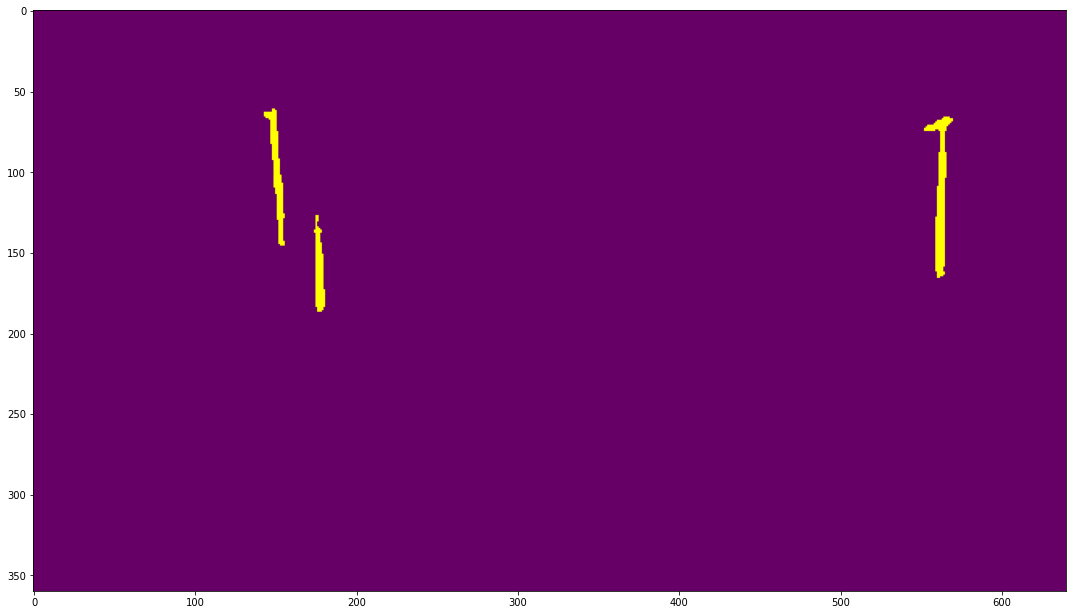

img_name = img_ref_0_stp_1_lat_63.7506190811_lon_-68.5155615407_hdg_284.910423279.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7506190811_lon_-68.5155615407_hdg_284.910423279.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7506190811_lon_-68.5155615407_hdg_284.910423279.png


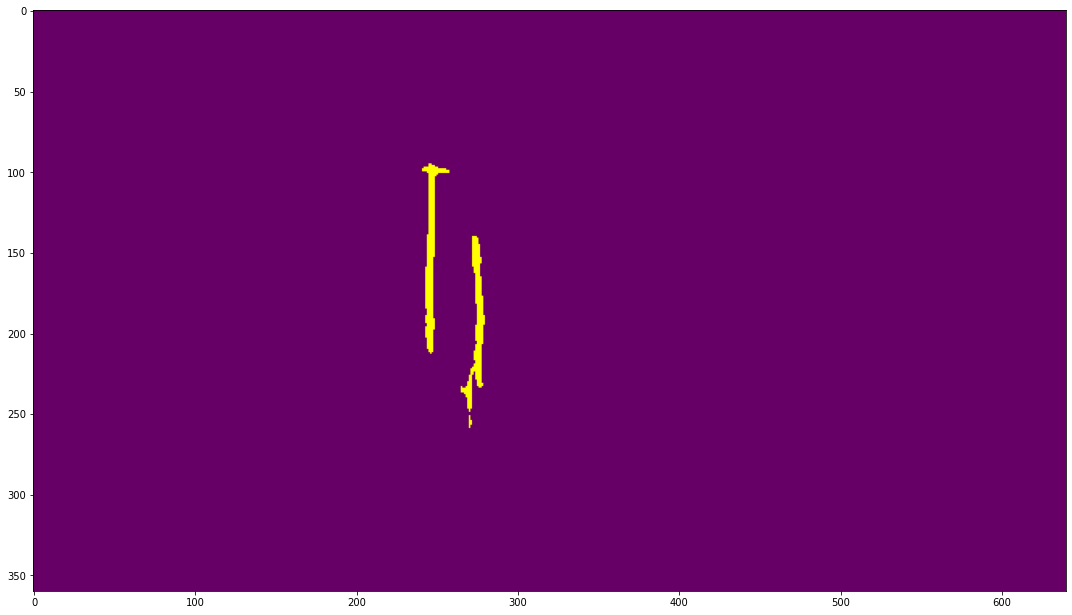

img_name = img_ref_0_stp_1_lat_63.750817373_lon_-68.4920191957_hdg_159.591220856.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.750817373_lon_-68.4920191957_hdg_159.591220856.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.750817373_lon_-68.4920191957_hdg_159.591220856.png


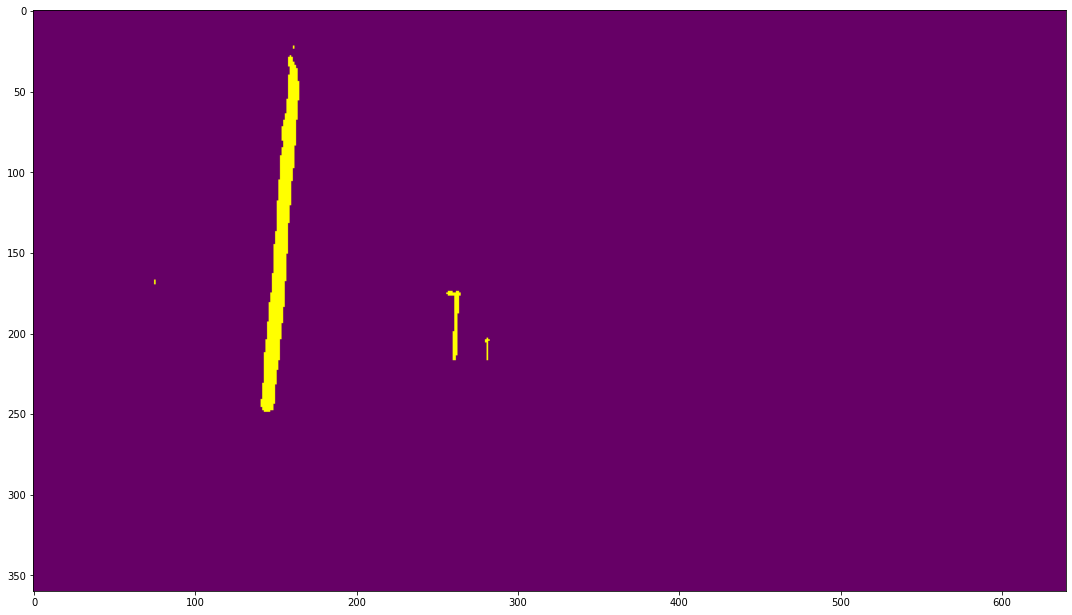

img_name = img_ref_0_stp_1_lat_63.750817436_lon_-68.5133626494_hdg_198.958860397.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.750817436_lon_-68.5133626494_hdg_198.958860397.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.750817436_lon_-68.5133626494_hdg_198.958860397.png


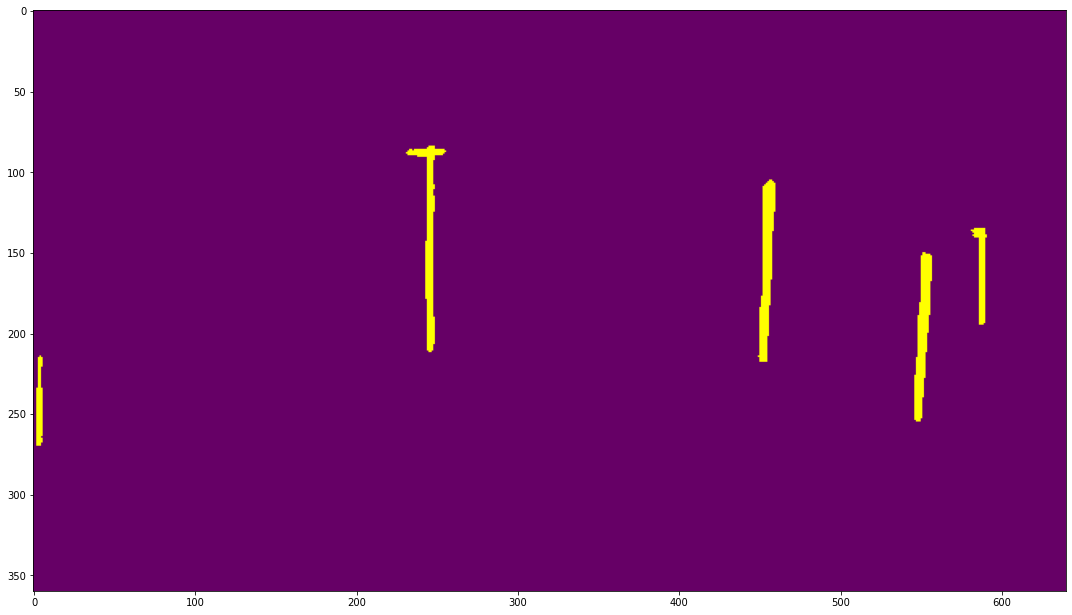

img_name = img_ref_0_stp_1_lat_63.7512106955_lon_-68.4924339267_hdg_515.536514282.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7512106955_lon_-68.4924339267_hdg_515.536514282.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7512106955_lon_-68.4924339267_hdg_515.536514282.png


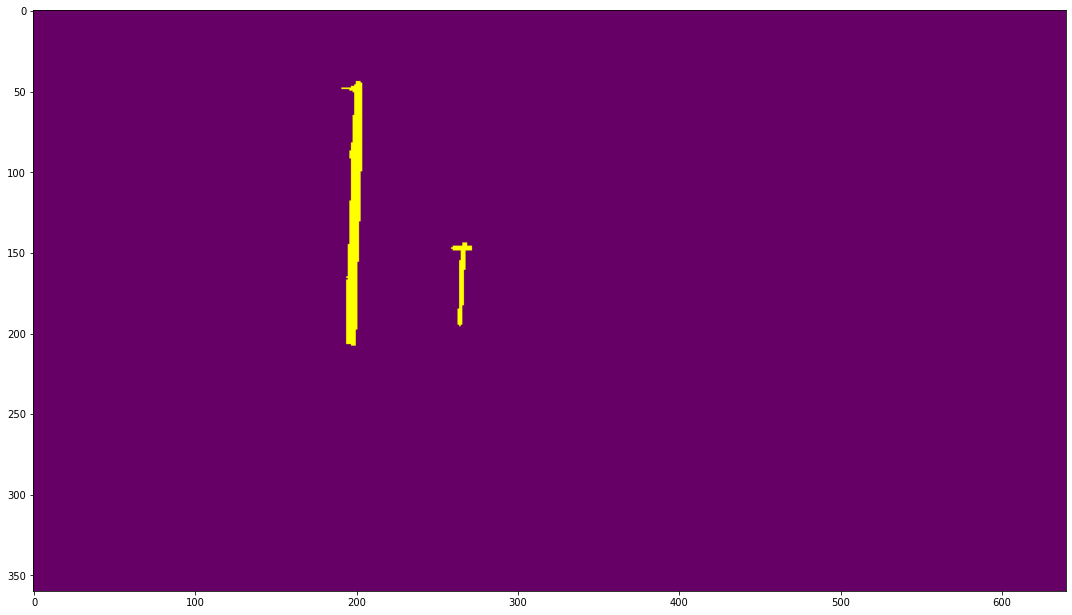

img_name = img_ref_0_stp_1_lat_63.751457384_lon_-68.5188185924_hdg_313.795913696.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.751457384_lon_-68.5188185924_hdg_313.795913696.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.751457384_lon_-68.5188185924_hdg_313.795913696.png


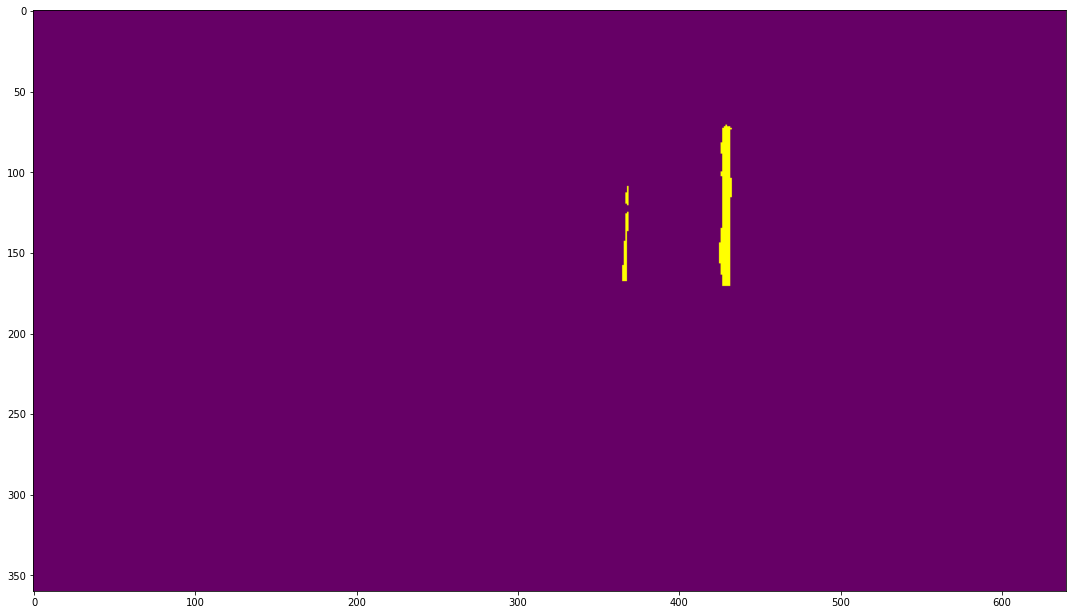

img_name = img_ref_0_stp_1_lat_63.7518678822_lon_-68.493267577_hdg_327.87531662.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7518678822_lon_-68.493267577_hdg_327.87531662.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7518678822_lon_-68.493267577_hdg_327.87531662.png


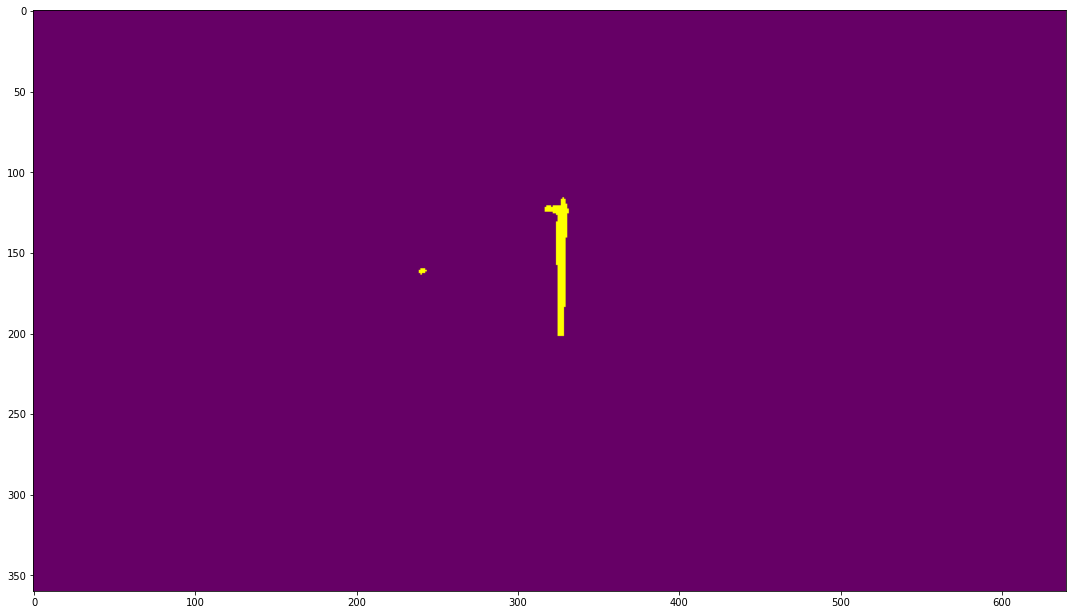

img_name = img_ref_0_stp_1_lat_63.7521343983_lon_-68.493775412_hdg_493.413375854.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7521343983_lon_-68.493775412_hdg_493.413375854.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7521343983_lon_-68.493775412_hdg_493.413375854.png


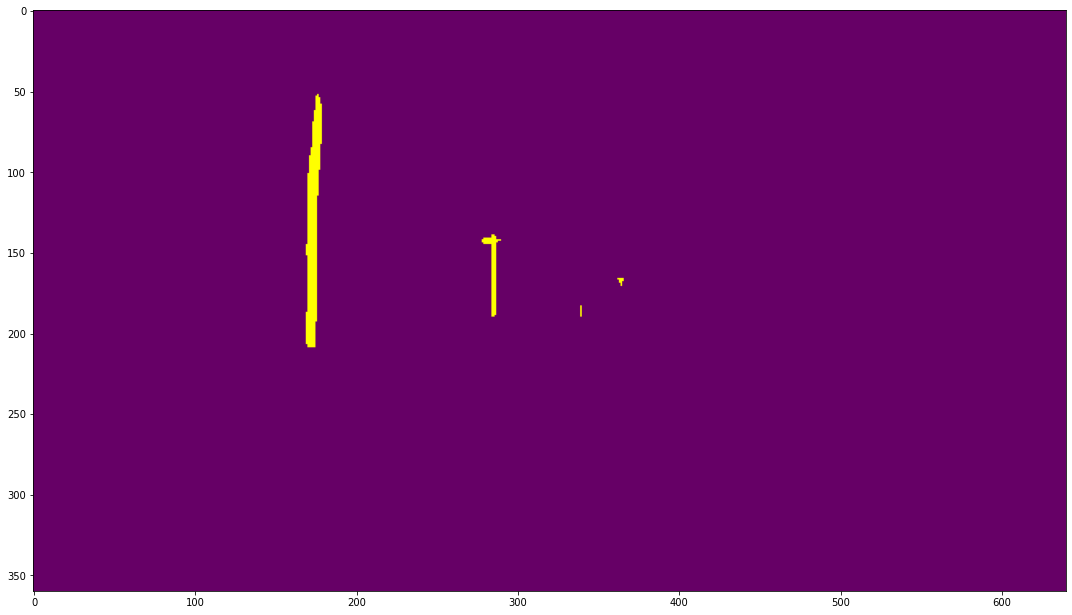

img_name = img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_293.220832825.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_293.220832825.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_293.220832825.png


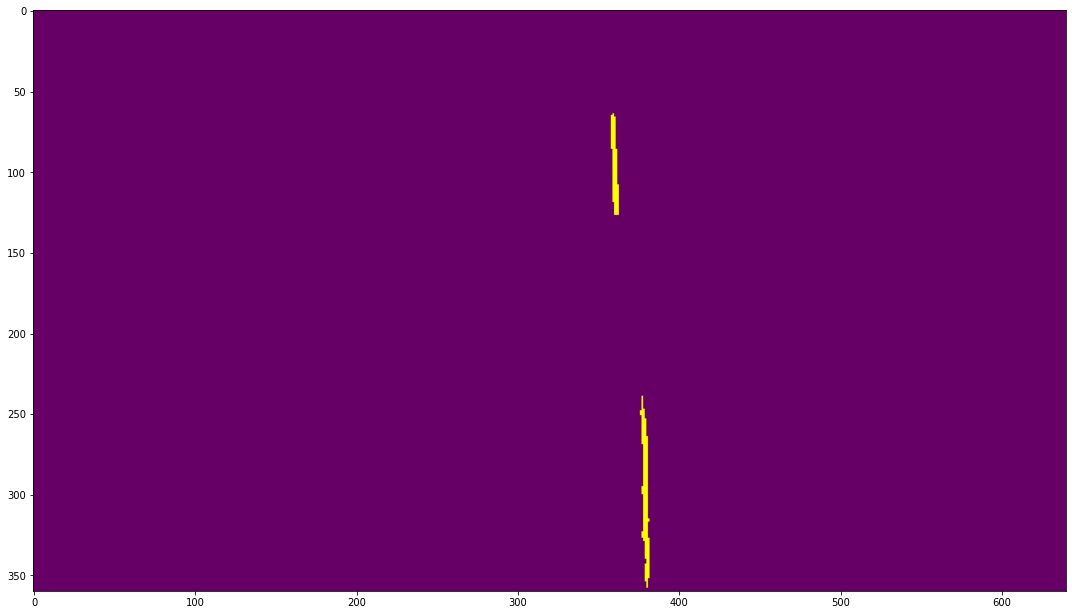

img_name = img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_473.220832825.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_473.220832825.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.752234018_lon_-68.5151304127_hdg_473.220832825.png


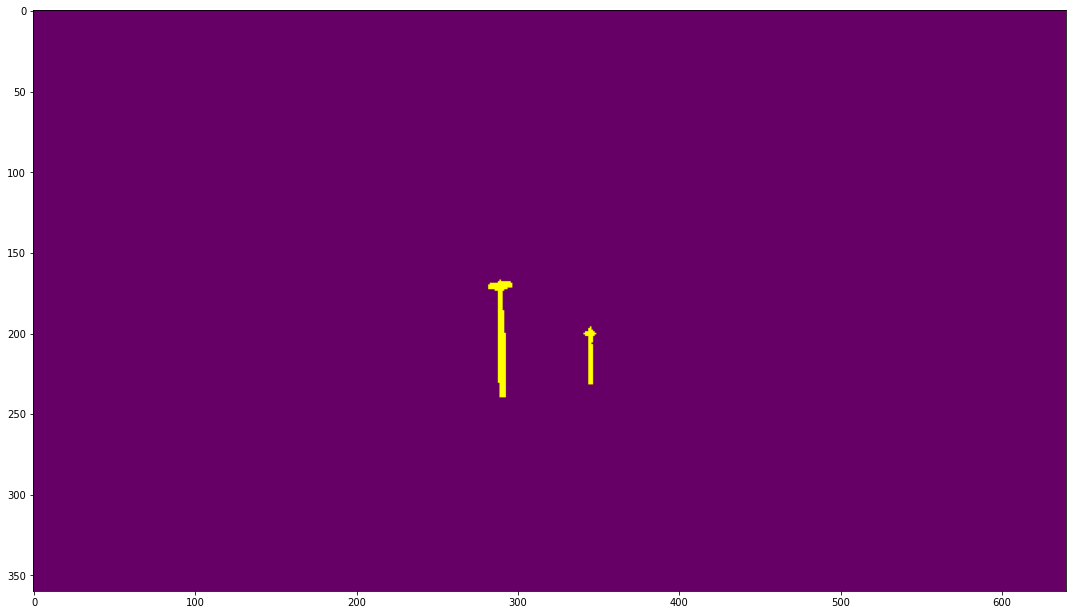

img_name = img_ref_0_stp_1_lat_63.7526837947_lon_-68.4971515567_hdg_176.928213358.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7526837947_lon_-68.4971515567_hdg_176.928213358.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7526837947_lon_-68.4971515567_hdg_176.928213358.png


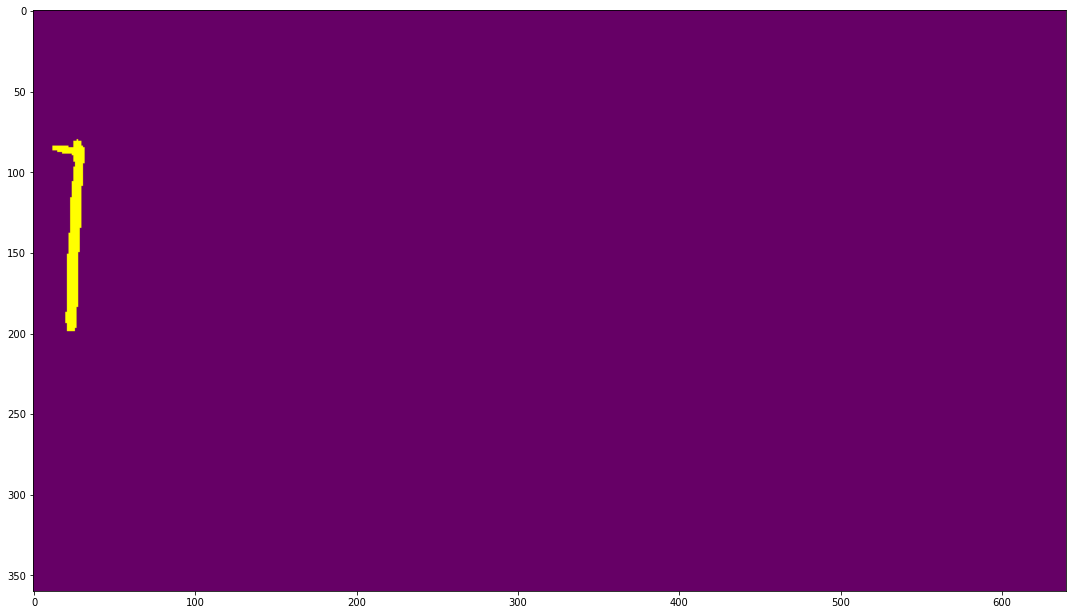

img_name = img_ref_0_stp_1_lat_63.7527809163_lon_-68.4955356499_hdg_127.778526306.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7527809163_lon_-68.4955356499_hdg_127.778526306.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7527809163_lon_-68.4955356499_hdg_127.778526306.png


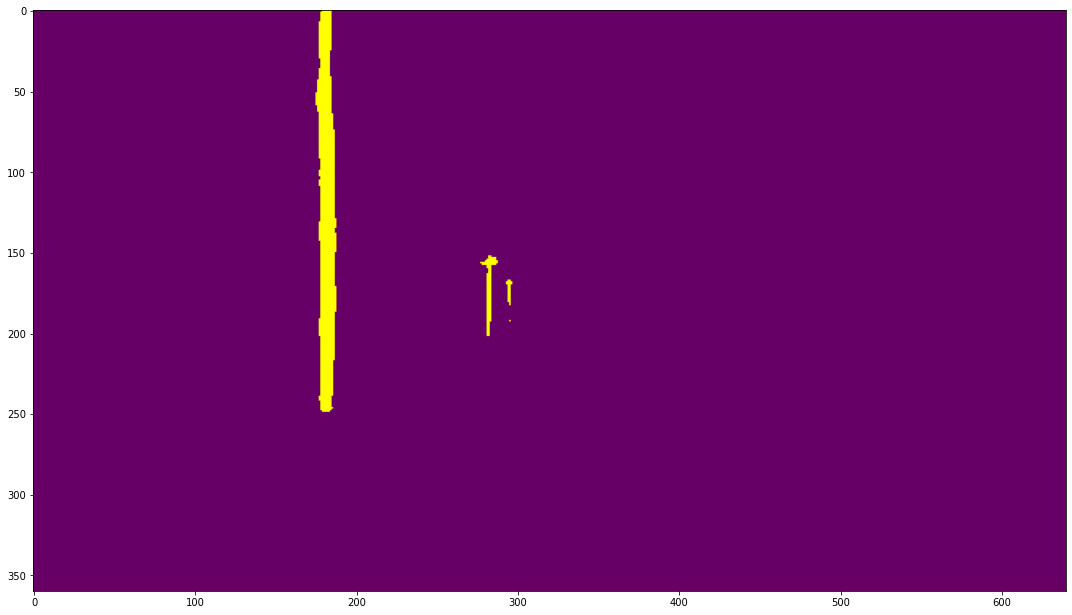

img_name = img_ref_0_stp_1_lat_63.7530280452_lon_-68.4964018336_hdg_113.929374695.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7530280452_lon_-68.4964018336_hdg_113.929374695.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7530280452_lon_-68.4964018336_hdg_113.929374695.png


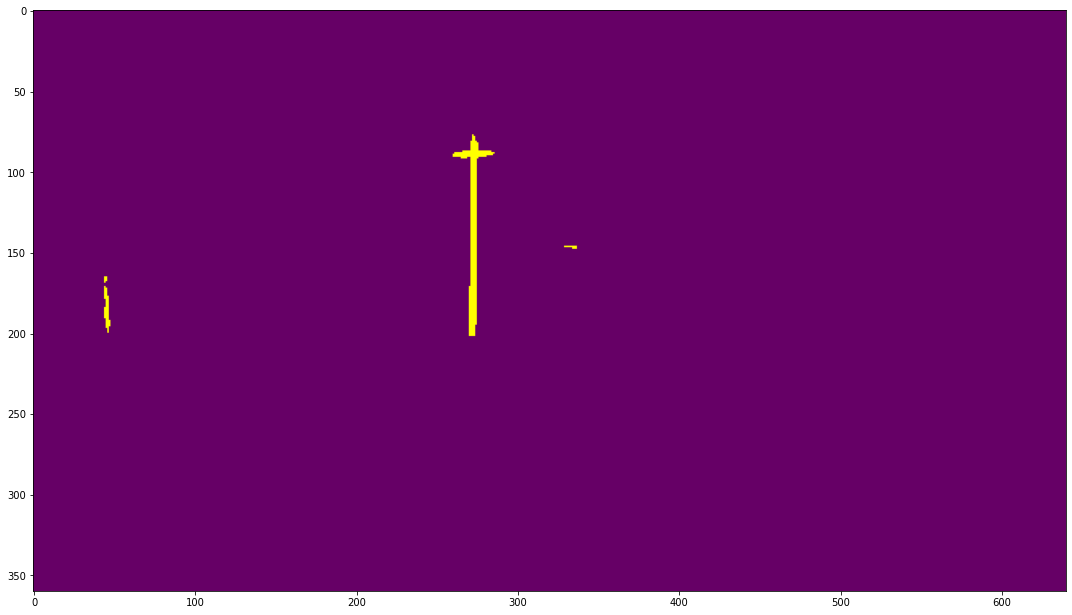

img_name = img_ref_0_stp_1_lat_63.7537939582_lon_-68.5153723906_hdg_323.517917633.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7537939582_lon_-68.5153723906_hdg_323.517917633.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7537939582_lon_-68.5153723906_hdg_323.517917633.png


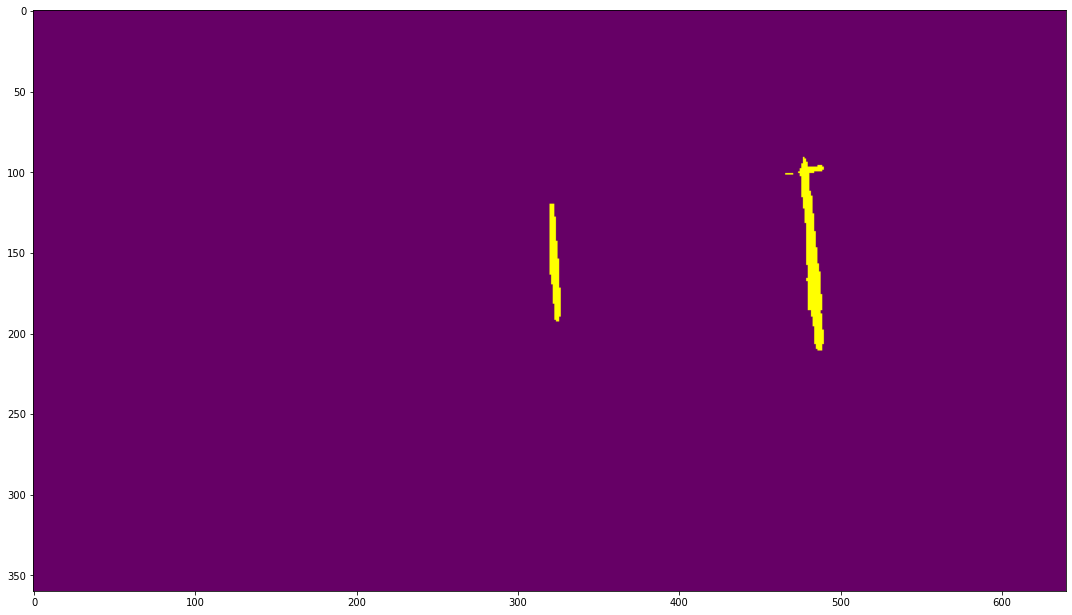

img_name = img_ref_0_stp_1_lat_63.7541849752_lon_-68.515768918_hdg_336.396591187.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7541849752_lon_-68.515768918_hdg_336.396591187.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7541849752_lon_-68.515768918_hdg_336.396591187.png


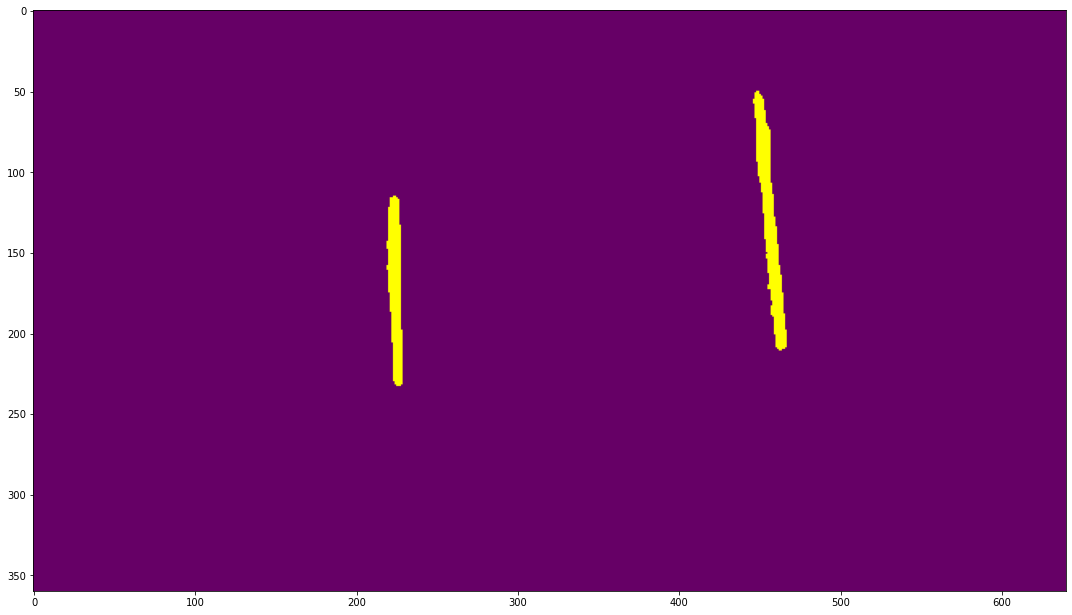

img_name = img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_318.052185059.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_318.052185059.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_318.052185059.png


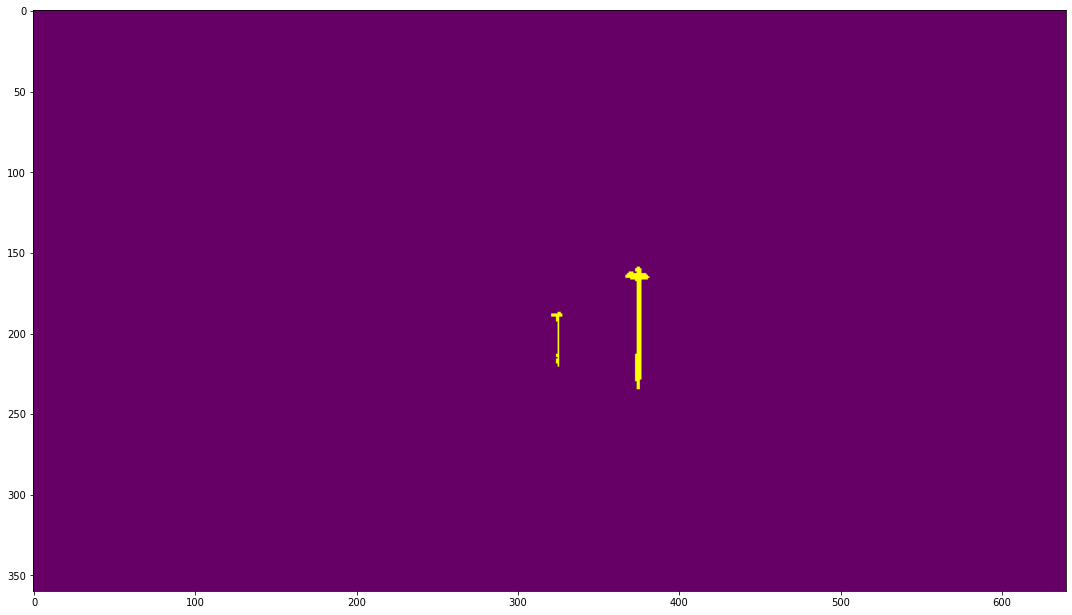

img_name = img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_498.052185059.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_498.052185059.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.754278889_lon_-68.5273193775_hdg_498.052185059.png


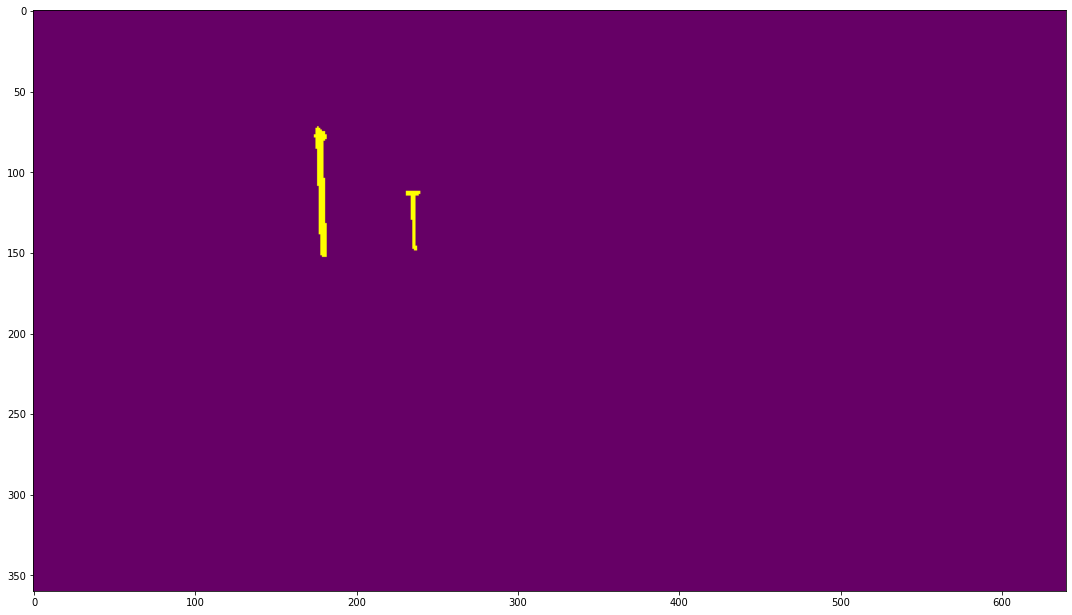

img_name = img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_314.871643066.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_314.871643066.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_314.871643066.png


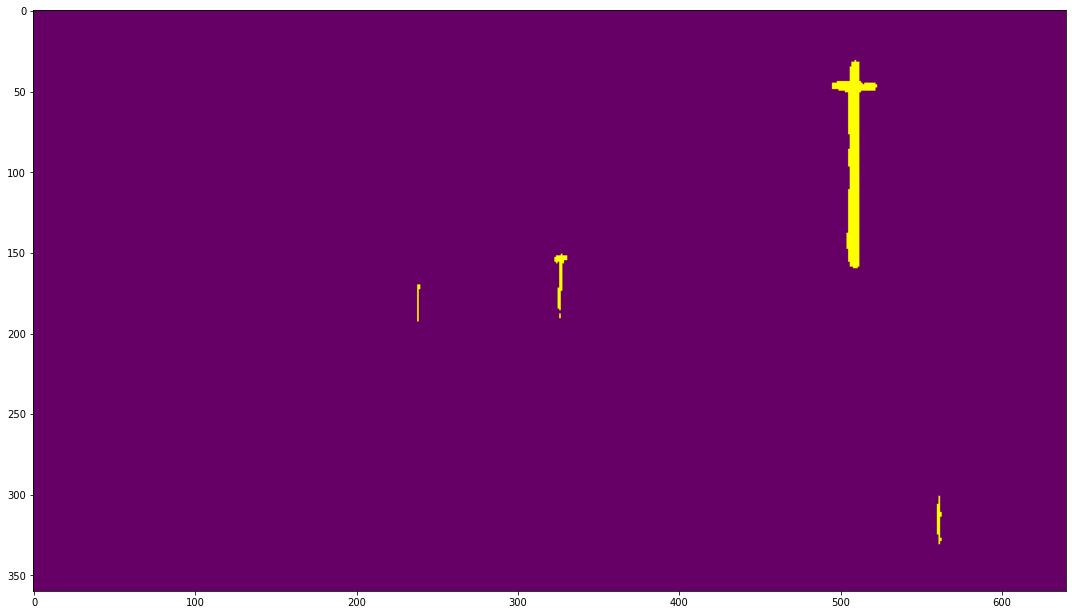

img_name = img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_494.871643066.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_494.871643066.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.754871988_lon_-68.528552593_hdg_494.871643066.png


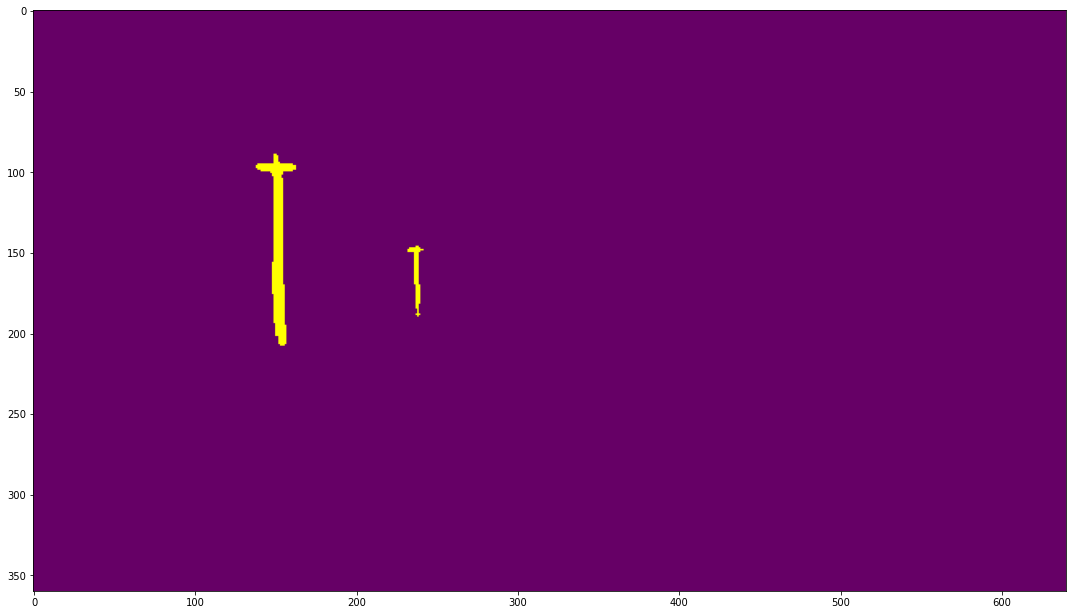

img_name = img_ref_0_stp_1_lat_63.7553185648_lon_-68.5168326515_hdg_157.872877121.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7553185648_lon_-68.5168326515_hdg_157.872877121.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7553185648_lon_-68.5168326515_hdg_157.872877121.png


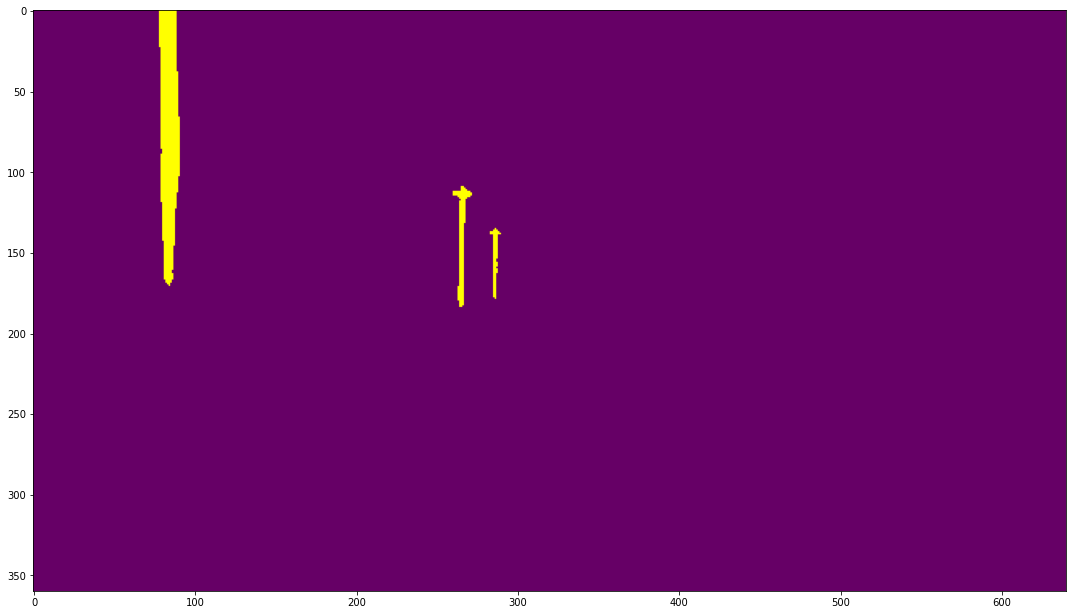

img_name = img_ref_0_stp_1_lat_63.7562537392_lon_-68.5342266703_hdg_316.581676483.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7562537392_lon_-68.5342266703_hdg_316.581676483.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7562537392_lon_-68.5342266703_hdg_316.581676483.png


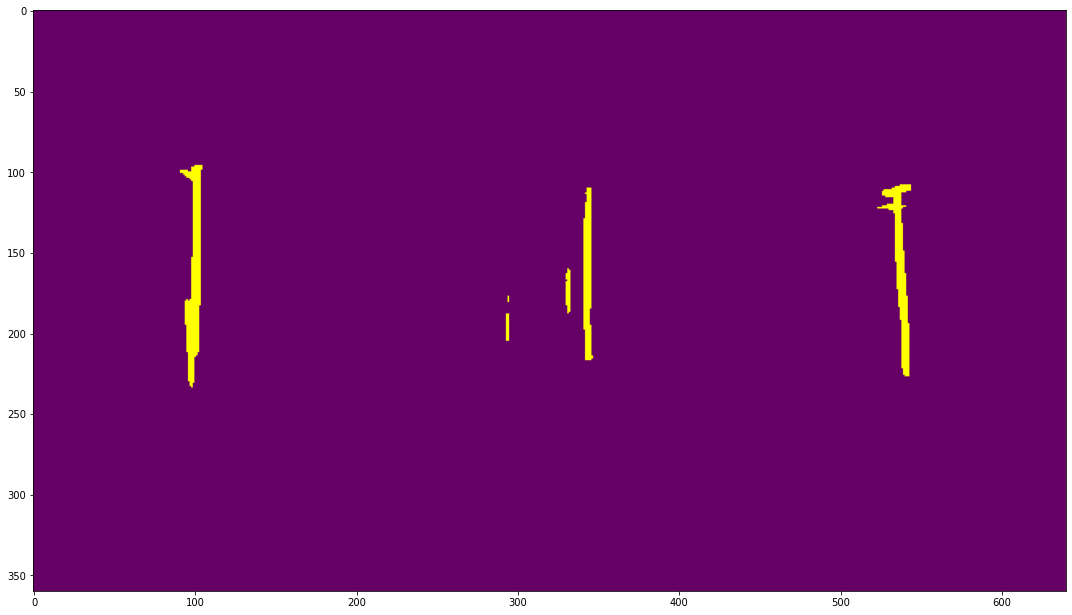

img_name = img_ref_0_stp_1_lat_63.7567057775_lon_-68.5352959914_hdg_314.747718811.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7567057775_lon_-68.5352959914_hdg_314.747718811.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7567057775_lon_-68.5352959914_hdg_314.747718811.png


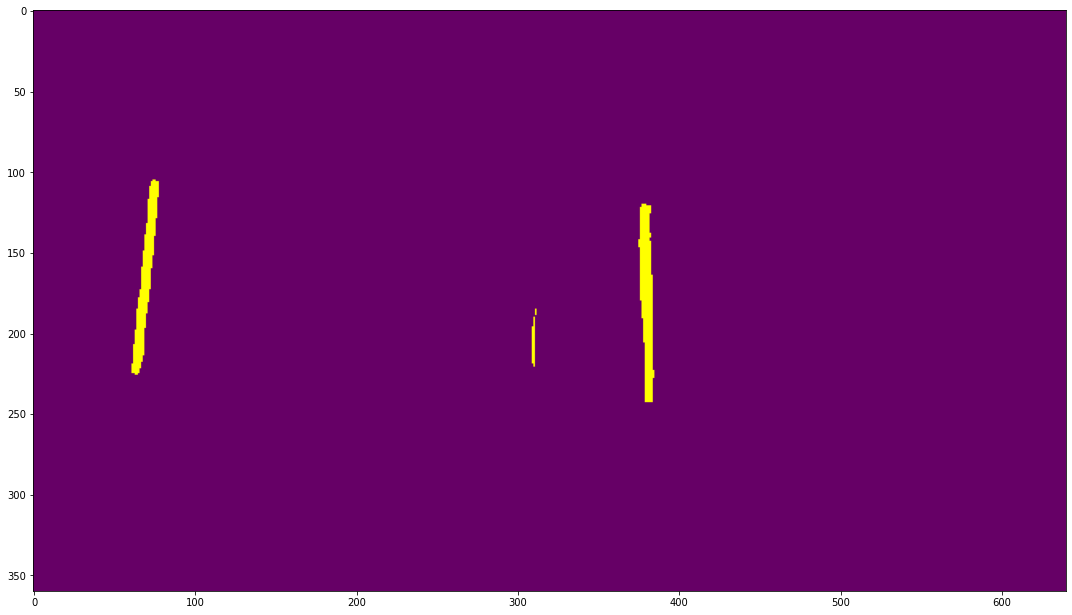

img_name = img_ref_0_stp_1_lat_63.7570901167_lon_-68.5387289096_hdg_223.464584351.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7570901167_lon_-68.5387289096_hdg_223.464584351.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7570901167_lon_-68.5387289096_hdg_223.464584351.png


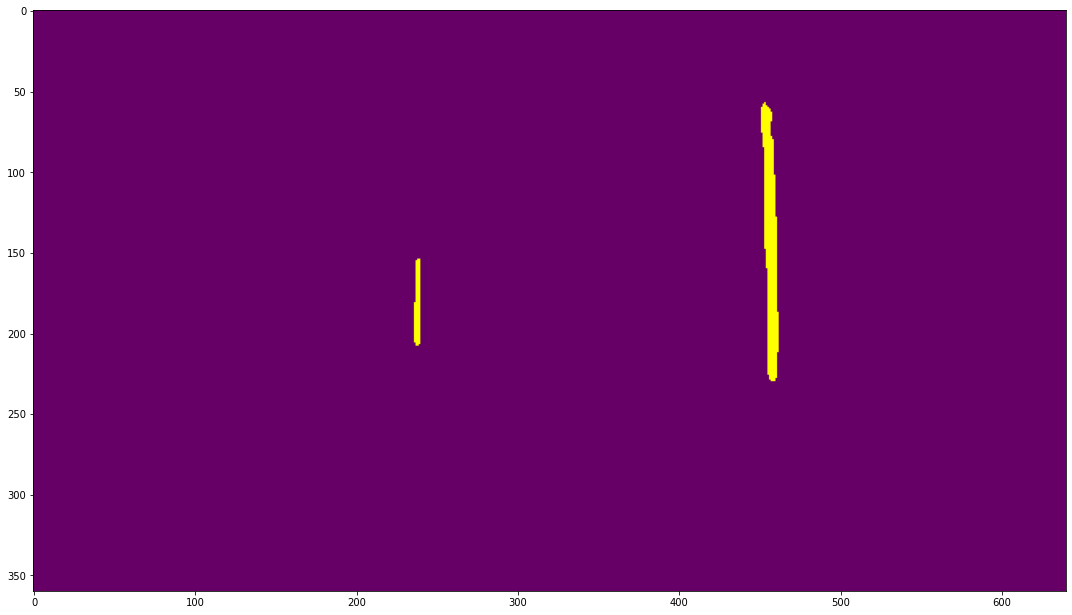

img_name = img_ref_0_stp_1_lat_63.7571195893_lon_-68.518167585_hdg_146.290950775.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7571195893_lon_-68.518167585_hdg_146.290950775.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7571195893_lon_-68.518167585_hdg_146.290950775.png


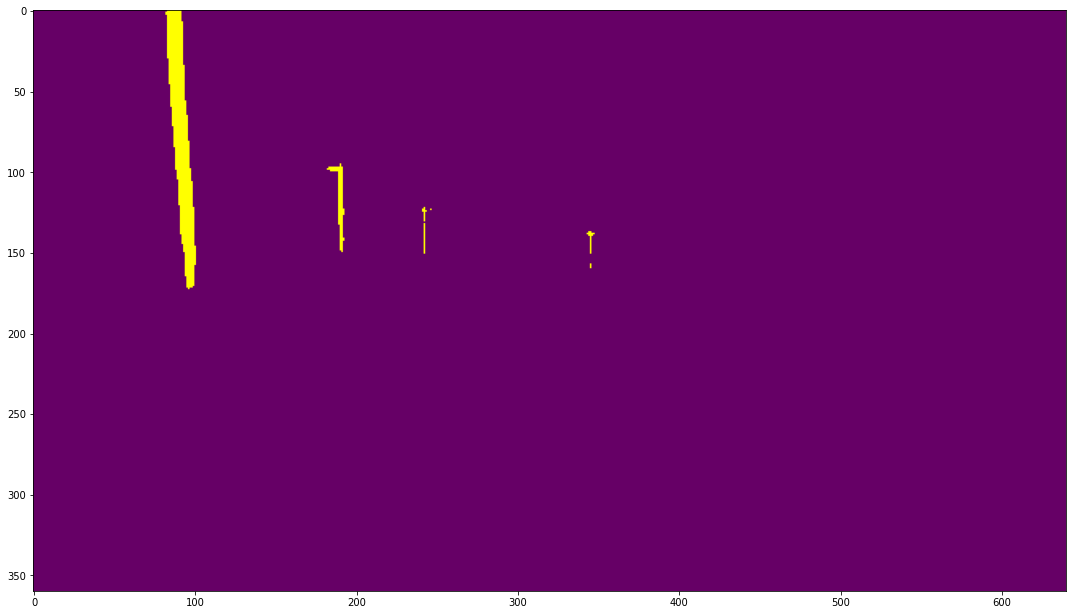

img_name = img_ref_0_stp_1_lat_63.7575397042_lon_-68.5201525888_hdg_268.541358948.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7575397042_lon_-68.5201525888_hdg_268.541358948.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7575397042_lon_-68.5201525888_hdg_268.541358948.png


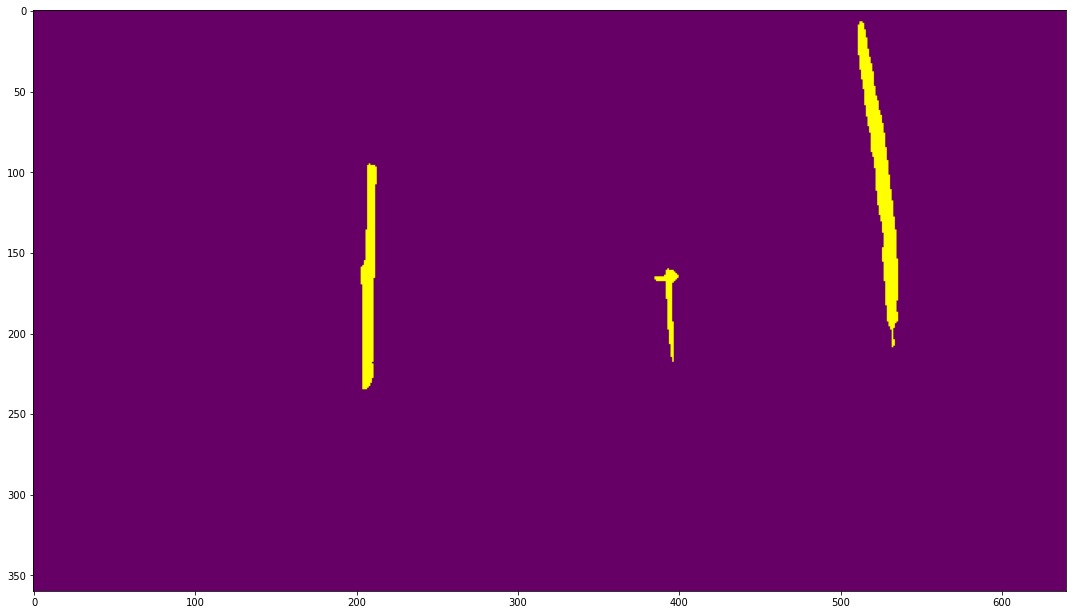

img_name = img_ref_0_stp_1_lat_63.757540384_lon_-68.5222363234_hdg_271.35243988.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.757540384_lon_-68.5222363234_hdg_271.35243988.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.757540384_lon_-68.5222363234_hdg_271.35243988.png


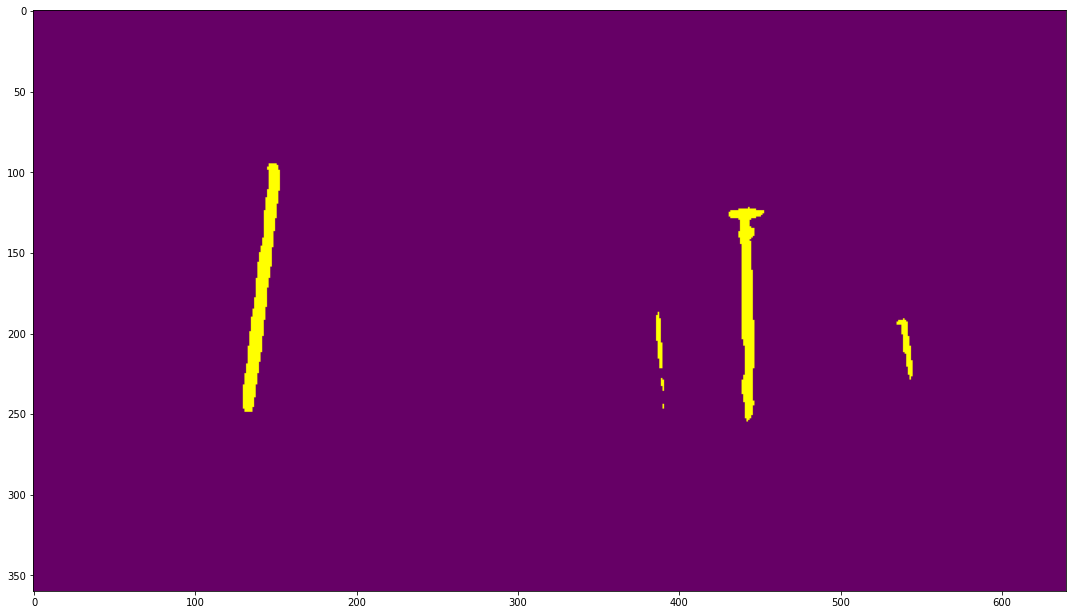

img_name = img_ref_0_stp_1_lat_63.7582221175_lon_-68.5235194978_hdg_159.729198456.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7582221175_lon_-68.5235194978_hdg_159.729198456.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7582221175_lon_-68.5235194978_hdg_159.729198456.png


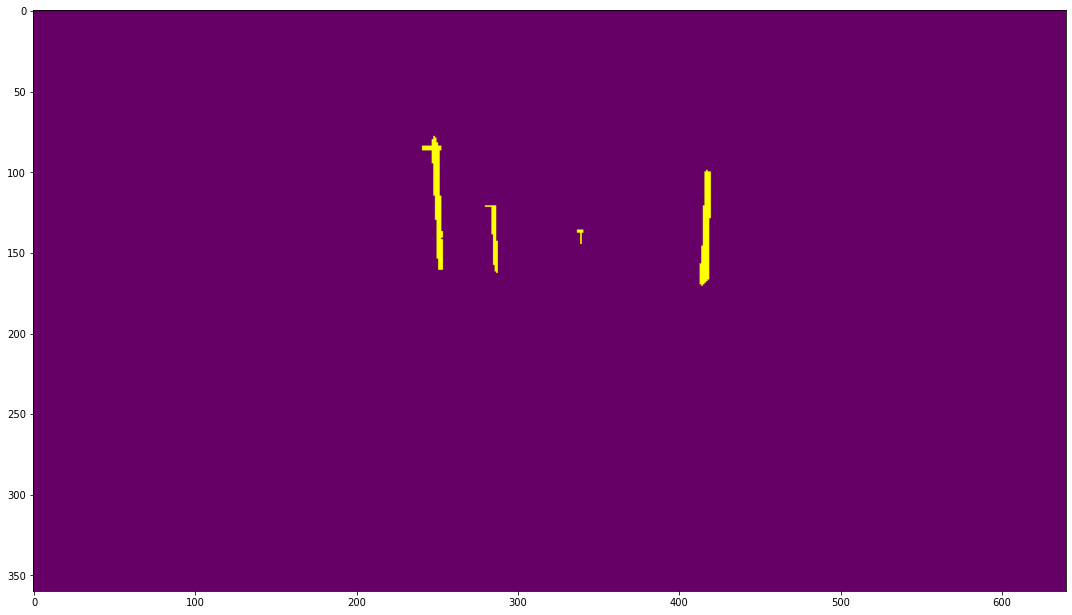

img_name = img_ref_0_stp_1_lat_63.7586697339_lon_-68.523948146_hdg_505.148101807.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7586697339_lon_-68.523948146_hdg_505.148101807.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7586697339_lon_-68.523948146_hdg_505.148101807.png


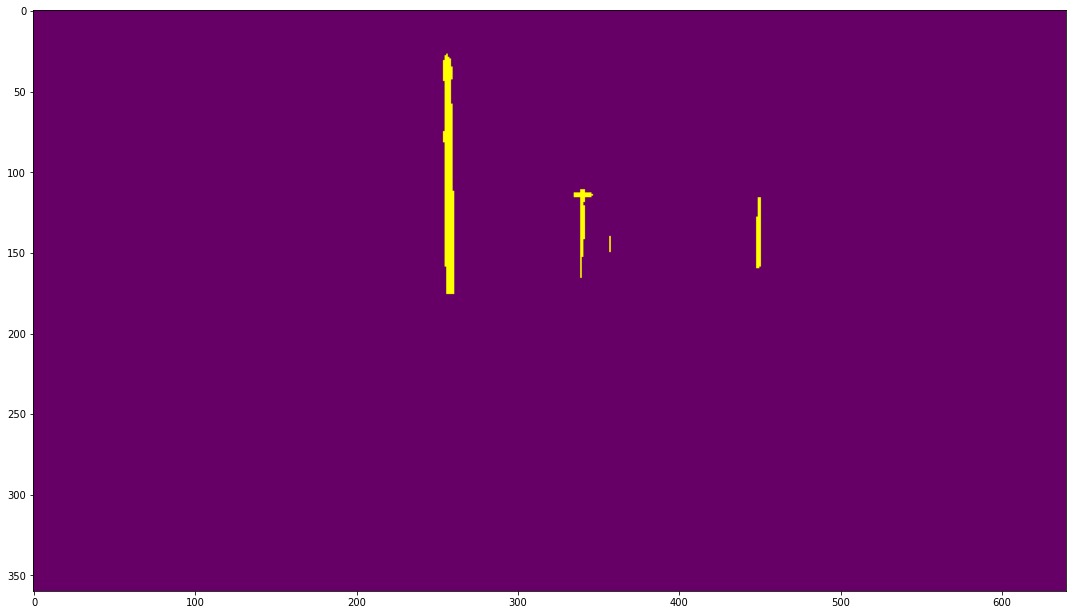

img_name = img_ref_0_stp_1_lat_63.7594757805_lon_-68.5423224869_hdg_228.315368652.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7594757805_lon_-68.5423224869_hdg_228.315368652.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7594757805_lon_-68.5423224869_hdg_228.315368652.png


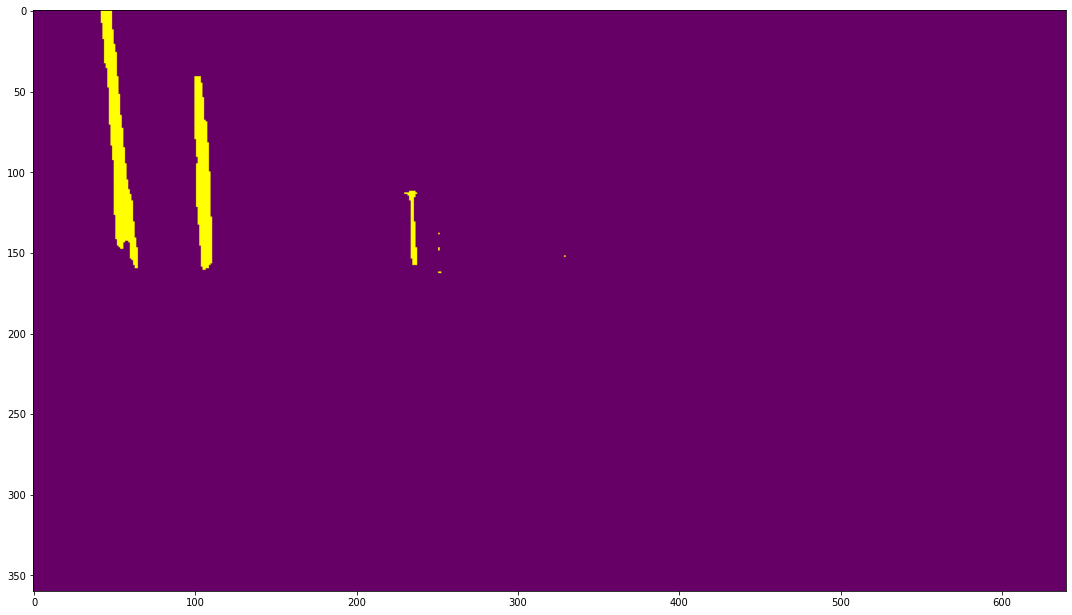

img_name = img_ref_0_stp_1_lat_63.7603534682_lon_-68.5401106432_hdg_229.360839844.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7603534682_lon_-68.5401106432_hdg_229.360839844.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7603534682_lon_-68.5401106432_hdg_229.360839844.png


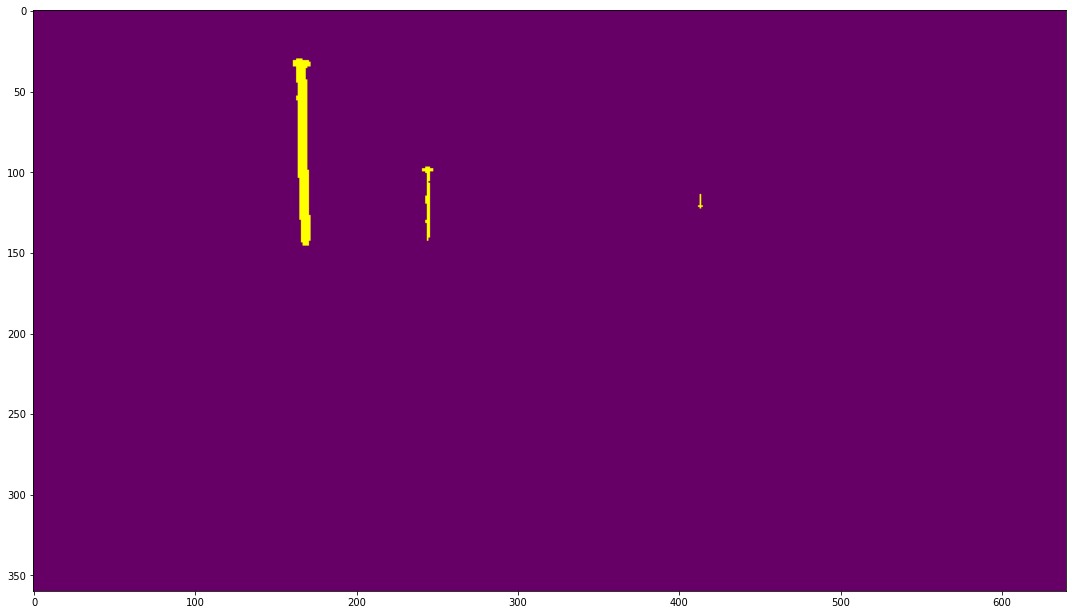

img_name = img_ref_0_stp_1_lat_63.7605285202_lon_-68.5257846537_hdg_520.501571655.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7605285202_lon_-68.5257846537_hdg_520.501571655.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7605285202_lon_-68.5257846537_hdg_520.501571655.png


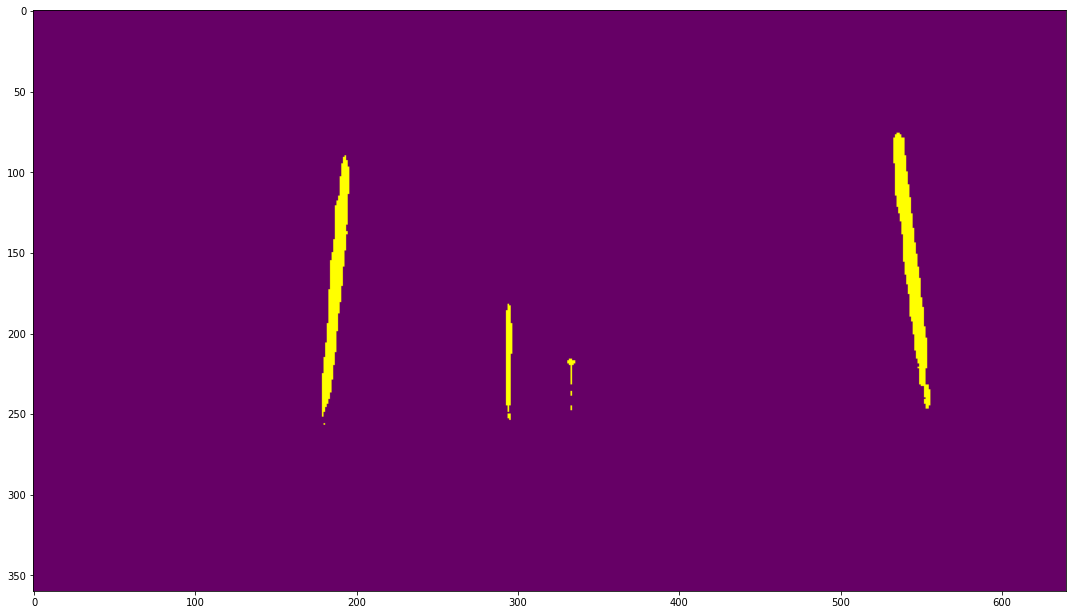

img_name = img_ref_0_stp_1_lat_63.7614992068_lon_-68.5388990705_hdg_151.561483383.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7614992068_lon_-68.5388990705_hdg_151.561483383.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7614992068_lon_-68.5388990705_hdg_151.561483383.png


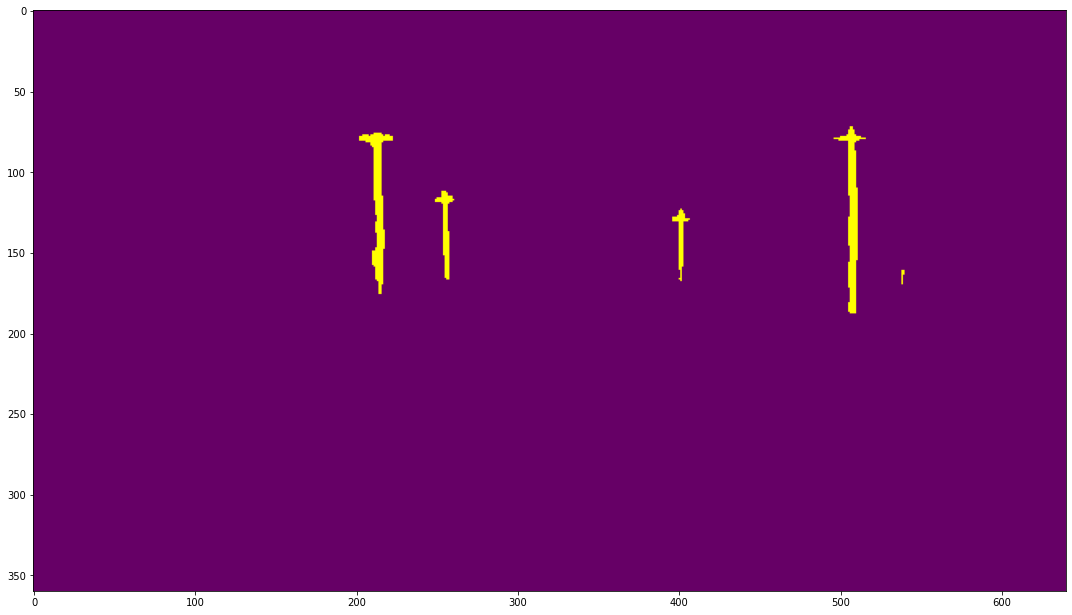

img_name = img_ref_0_stp_1_lat_63.7615890956_lon_-68.539000028_hdg_335.286422729.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7615890956_lon_-68.539000028_hdg_335.286422729.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7615890956_lon_-68.539000028_hdg_335.286422729.png


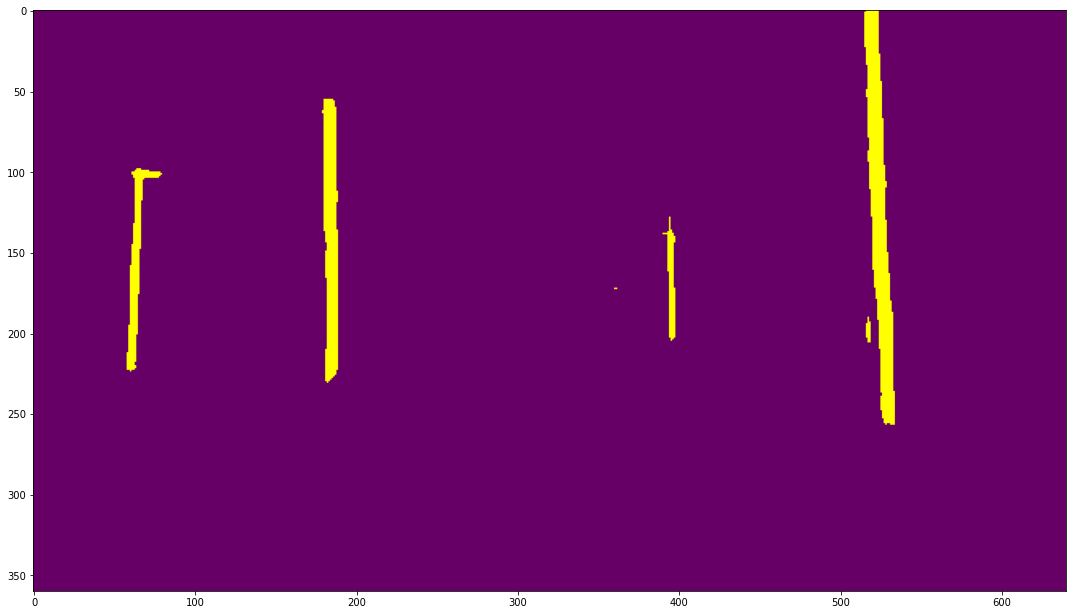

img_name = img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_140.789077759.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_140.789077759.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_140.789077759.png


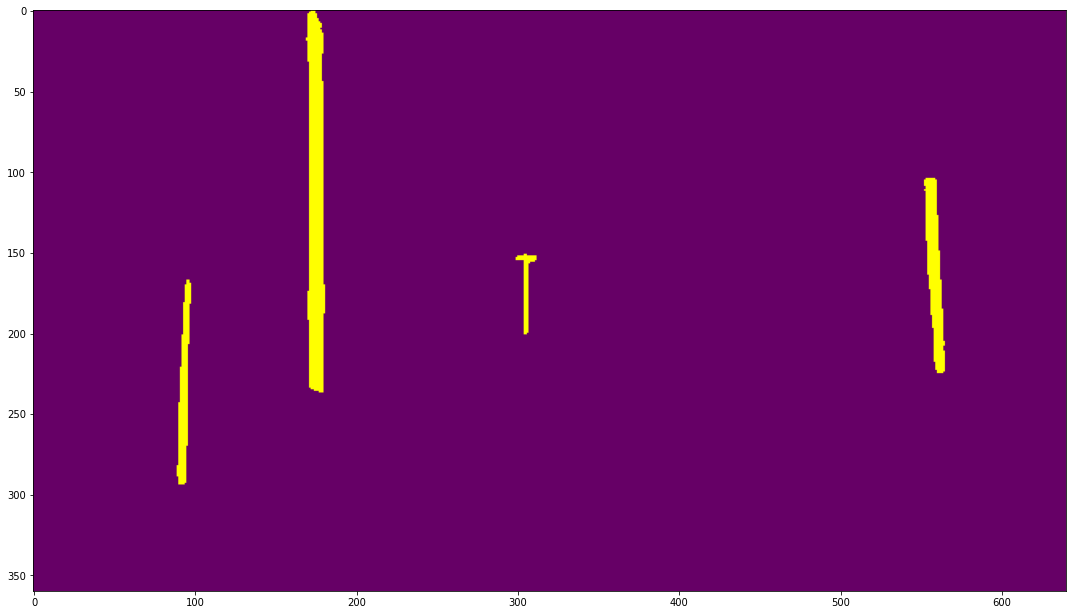

img_name = img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_320.789077759.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_320.789077759.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.761672704_lon_-68.544506082_hdg_320.789077759.png


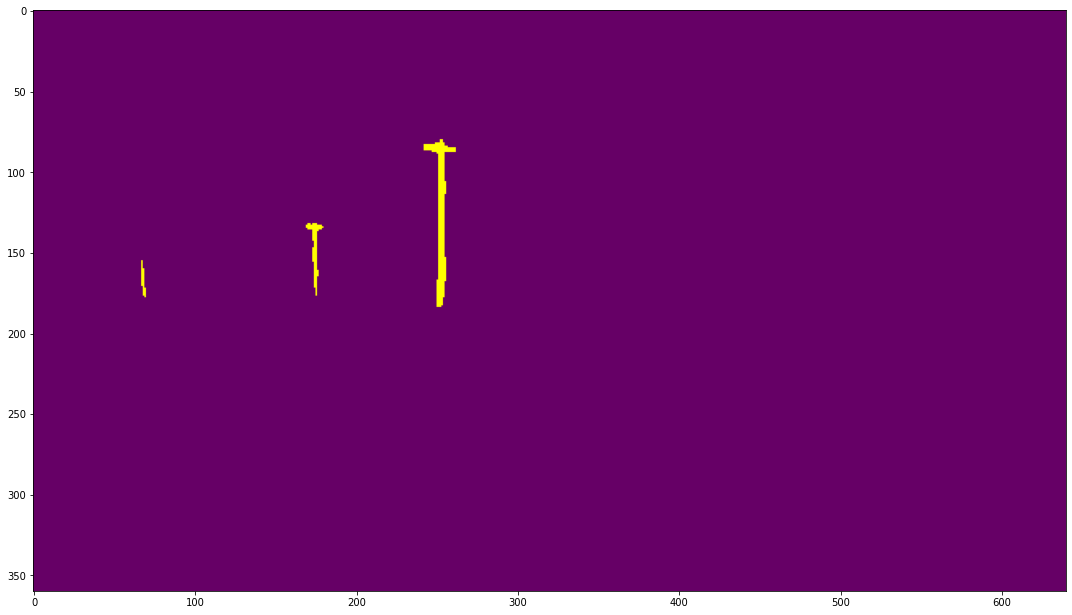

img_name = img_ref_0_stp_1_lat_63.7622183046_lon_-68.5284349384_hdg_328.809036255.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7622183046_lon_-68.5284349384_hdg_328.809036255.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7622183046_lon_-68.5284349384_hdg_328.809036255.png


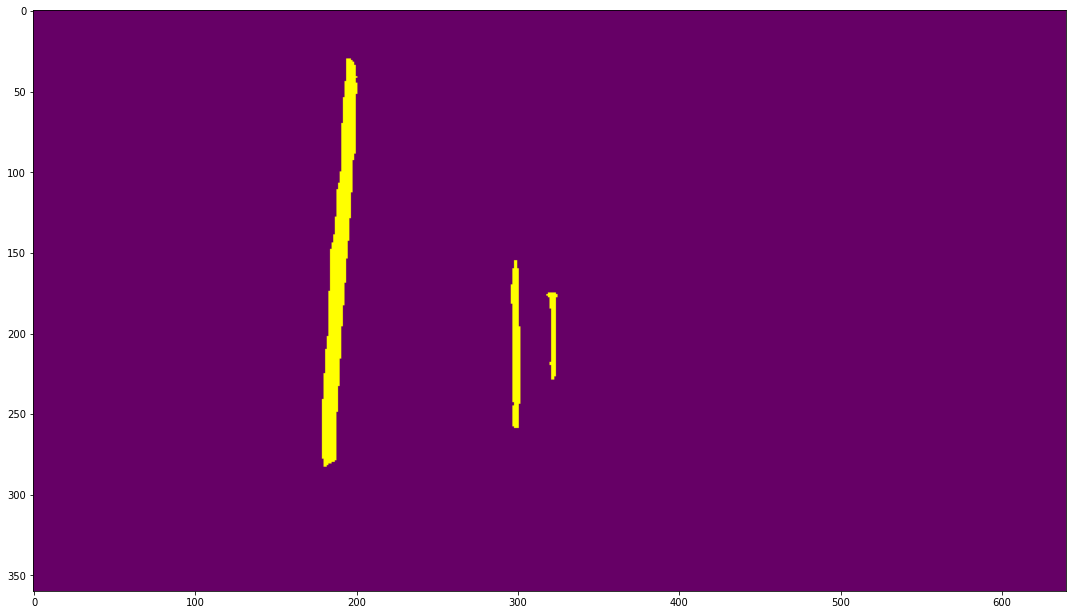

img_name = img_ref_0_stp_1_lat_63.764032475_lon_-68.5303999476_hdg_515.449310303.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.764032475_lon_-68.5303999476_hdg_515.449310303.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.764032475_lon_-68.5303999476_hdg_515.449310303.png


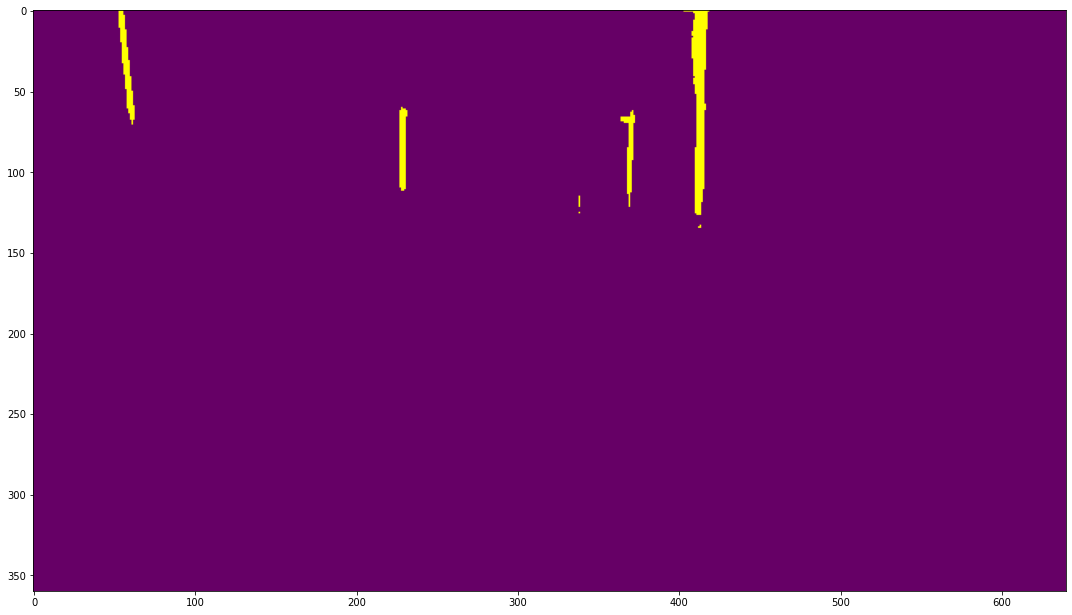

img_name = img_ref_0_stp_1_lat_63.7643630817_lon_-68.530765069_hdg_513.665145874.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7643630817_lon_-68.530765069_hdg_513.665145874.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7643630817_lon_-68.530765069_hdg_513.665145874.png


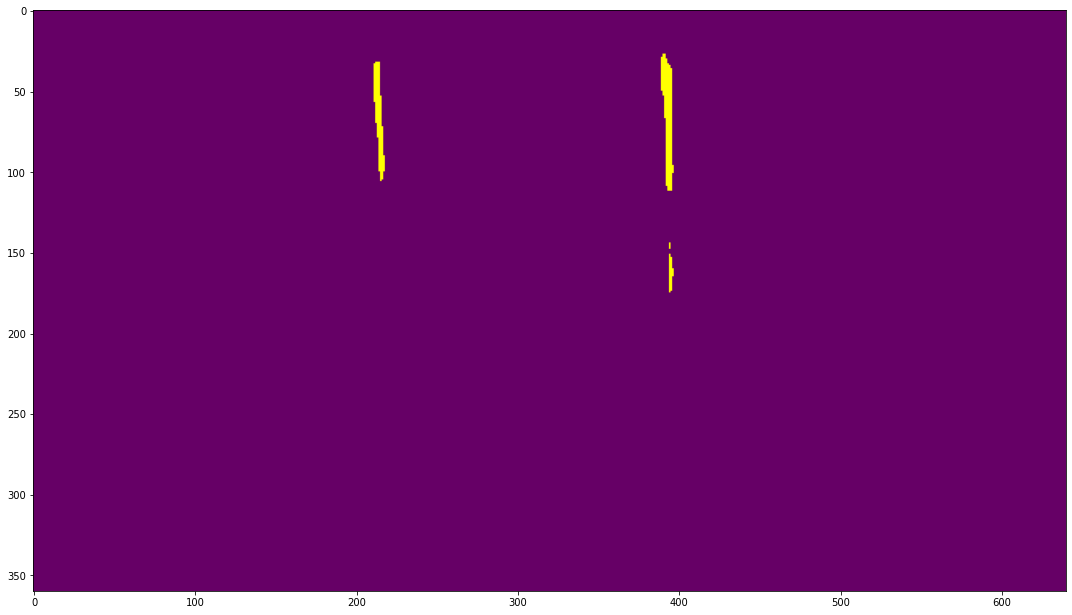

img_name = img_ref_0_stp_1_lat_63.7651110925_lon_-68.5316666894_hdg_512.353027344.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7651110925_lon_-68.5316666894_hdg_512.353027344.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7651110925_lon_-68.5316666894_hdg_512.353027344.png


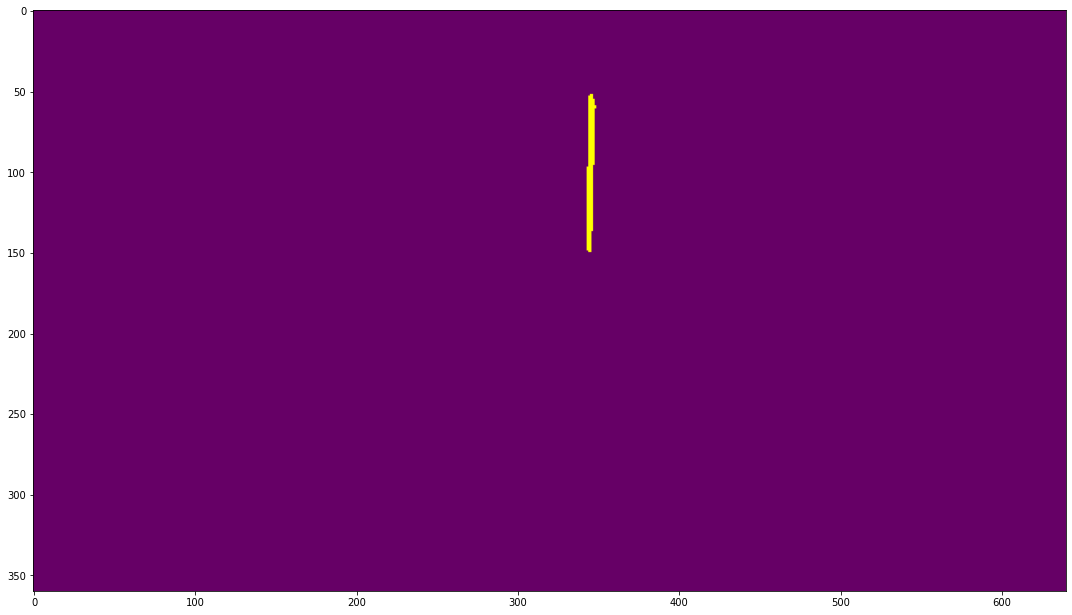

img_name = img_ref_0_stp_1_lat_63.7659210629_lon_-68.5329590762_hdg_140.545768738.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7659210629_lon_-68.5329590762_hdg_140.545768738.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7659210629_lon_-68.5329590762_hdg_140.545768738.png


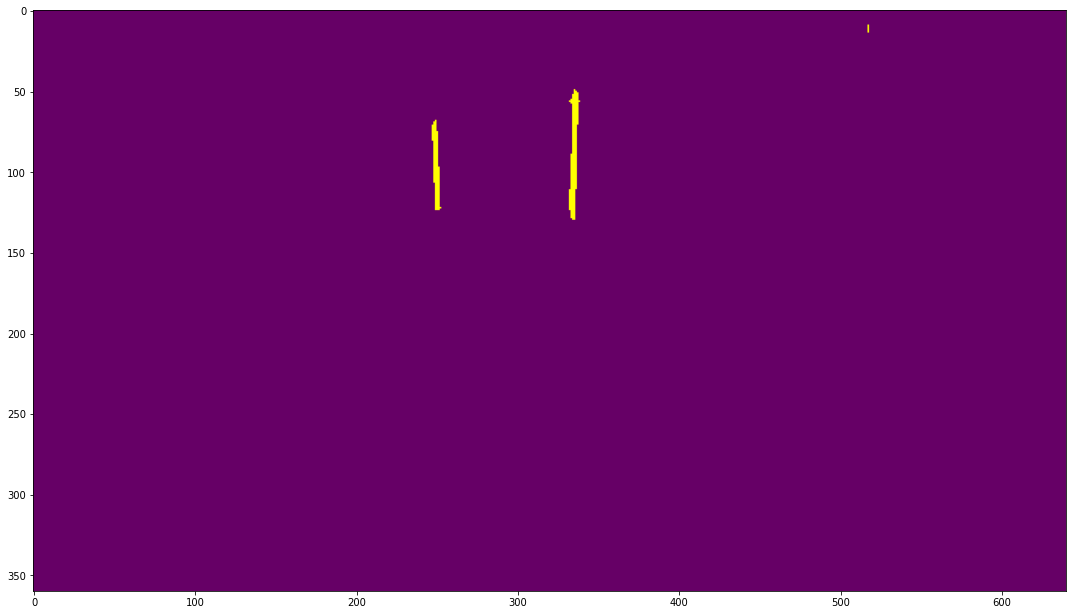

img_name = img_ref_0_stp_1_lat_63.7681035033_lon_-68.5361008861_hdg_164.448447227.png
img = /content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/img_dir/train/img_ref_0_stp_1_lat_63.7681035033_lon_-68.5361008861_hdg_164.448447227.jpg
img_filename = predictions/img_ref_0_stp_1_lat_63.7681035033_lon_-68.5361008861_hdg_164.448447227.png


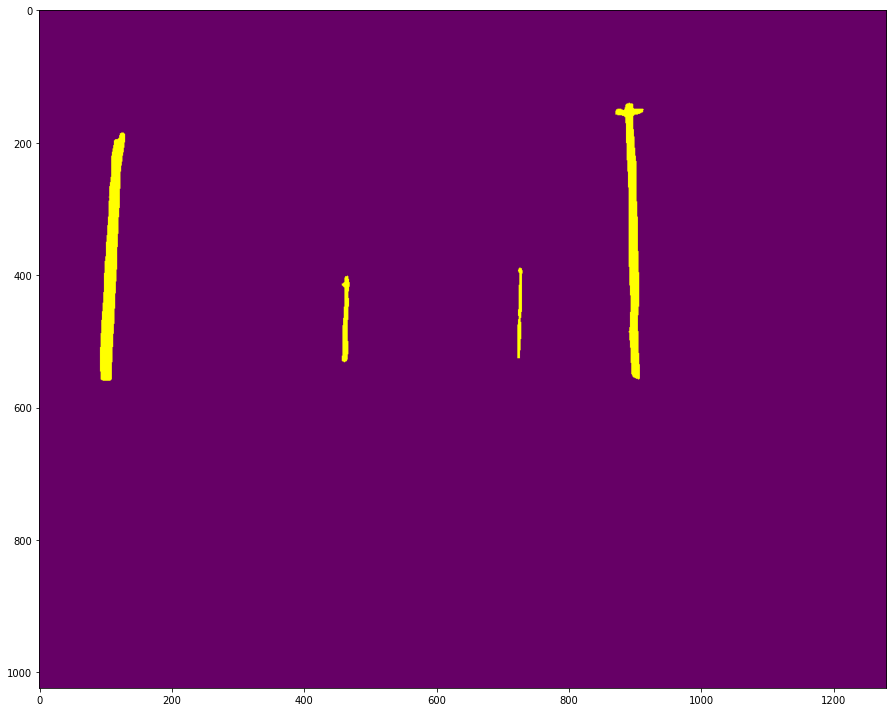

41


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile

TEST_IMAGE_PATHS = []
LABEL_PATHS = []

PATH_TO_TEST_IMAGES_DIR= data_root + dataset + "/img_dir/train"
PATH_TO_LABEL_IMAGES_DIR= data_root + dataset + "/ann_dir/train"

for i in filename_list_test:
  TEST_IMAGE_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, (i + '.jpg')))
  LABEL_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, (i + '.png')))

#TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
#LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TEST_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

print(len(LABEL_PATHS))

res_palette = [[102, 0, 102],[255,255,0]]

count = 0

for i in range(0,len(TEST_IMAGE_PATHS)):
  img_name= LABEL_PATHS[i].split("/")[8] #FOR MASK
  print("img_name = " + img_name)

  # test a single image
  # img = 'demo/img_ref_0_stp_1_lat_44.7421413949_lon_-75.5405596442_hdg_331.905227661.jpg'
  # img = TEST_IMAGE_PATHS[i]
  print("img = " + TEST_IMAGE_PATHS[i])
  img = mmcv.imread(TEST_IMAGE_PATHS[i])

  # print("img: " + img)
  model.cfg = cfg
  result = inference_segmentor(model, img)
  
  # show the results and save prediction
  image_filename = "predictions/"+ img_name
  print("img_filename = " + image_filename)

  show_result_pyplot(model, img, result, res_palette, opacity=1, out_file=image_filename)

  count = count + 1

print(count)
 

# Save predictions and checkpoints

In [ ]:
import shutil

# save predictions
%cp -av "/content/mmsegmentation/predictions/" "/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluitY/"

'/content/mmsegmentation/predictions/' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluitY/'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.7500012498_lon_-68.5178226613_hdg_326.151340485.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluitY/img_ref_0_stp_1_lat_63.7500012498_lon_-68.5178226613_hdg_326.151340485.png'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.7506190811_lon_-68.5155615407_hdg_284.910423279.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluitY/img_ref_0_stp_1_lat_63.7506190811_lon_-68.5155615407_hdg_284.910423279.png'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.750817373_lon_-68.4920191957_hdg_159.591220856.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluitY/img_ref_0_stp_1_lat_63.750817373_lon_-68.4920191957_hdg_159.591220856.png'
'/content/mmsegmentation/predictions/img_ref_0_stp_1_lat_63.750817436_lon_

In [64]:
shutil.copy("/content/mmsegmentation/work_dirs/tutorial/None.log.json", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/Waterloo.log.json")

'/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/Waterloo.log.json'

In [65]:
shutil.copy("/content/mmsegmentation/work_dirs/tutorial/iter_1000.pth", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/waterloo_final.pth")

'/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/waterloo_final.pth'

In [ ]:
shutil.copy("/content/mmsegmentation/data/splits/train.txt", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/waterloo_final_train.txt")
shutil.copy("/content/mmsegmentation/data/splits/val.txt", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/waterloo_final_val.txt")

'/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/waterloo_final_val.txt'

In [ ]:
import shutil

# save predictions
%cp -av "/content/mmsegmentation/predictions/" "/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/"

# save last checkpoint
if path.exists("/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/") == False:
  os.mkdir("/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/")

shutil.copy("/content/mmsegmentation/work_dirs/tutorial/iter_1000.pth", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/iter_1000_iqaluit_all.pth")

# save log file
shutil.copy("/content/mmsegmentation/work_dirs/tutorial/None.log.json", "/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/None.log.json")


'/content/mmsegmentation/predictions/' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/predictions'
'/content/mmsegmentation/predictions/2018_03_06_0001_image_02_0000000071.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/predictions/2018_03_06_0001_image_02_0000000071.png'
'/content/mmsegmentation/predictions/2018_03_06_0001_image_02_0000000097.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/predictions/2018_03_06_0001_image_02_0000000097.png'
'/content/mmsegmentation/predictions/2018_03_06_0001_image_04_0000000076.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/predictions/2018_03_06_0001_image_04_0000000076.png'
'/content/mmsegmentation/predictions/2018_03_06_0001_image_05_0000000074.png' -> '/content/drive/MyDrive/NRCan2022/predictions_hrnet_finetuned_poles/iqaluit/waterloo/predictions/2018_03_06_0001_image_05_

'/content/drive/MyDrive/NRCan2022/model_checkpoint_finetuned_poles_hrnet/None.log.json'

## Evaluation on Test Set
Calcutate the IOU between the prediction images and the corresponding binary masks

1. Download the binary masks
2. USe IOU function to measure IOU

In [ ]:
test_ann_1 = "/content/mmsegmentation/data_NRCan2022_hrnet/poles/iqaluit/ann_dir/train"
#TEST_LABEL_PATHS_1 = glob.glob(os.path.join(test_ann_1, "*.png"))

test_ann_2 = "/content/mmsegmentation/data_NRCan2022_hrnet/poles/waterloo/ann_dir/train"
#TEST_LABEL_PATHS_2 = glob.glob(os.path.join(test_ann_2, "*.png"))

pred = "/content/mmsegmentation/predictions/"
PRED_LABEL_PATHS = glob.glob(os.path.join(pred, "*.png"))

#TEST_LABEL_PATHS = TEST_LABEL_PATHS_1 + TEST_LABEL_PATHS_2

TEST_LABEL_PATHS = LABEL_PATHS

TEST_LABEL_PATHS.sort()
PRED_LABEL_PATHS.sort()

count = 0

for i in range(0, len(PRED_LABEL_PATHS)):
  image_path = test_ann_1 + "/" + PRED_LABEL_PATHS[i].split("/")[4]
  if os.path.exists(image_path):
    count = count + 1
  else:
    image_path = test_ann_2 + "/" + PRED_LABEL_PATHS[i].split("/")[4]
    if os.path.exists(image_path):
      count = count + 1
  #if TEST_LABEL_PATHS[i].split("/")[8] == PRED_LABEL_PATHS[i].split("/")[4]:
  #if image_path.split("/")[8] == PRED_LABEL_PATHS[i].split("/")[4]:
    #count = count + 1
count

41

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import zipfile
from PIL import Image

iou_sum = []
iou_sum_i = []
iou_sum_w = []
poles_gt = []
flag_i = 0
flag_w = 0

for a in range(0, len(PRED_LABEL_PATHS)):
  im1 = Image.open(PRED_LABEL_PATHS[a], "r")
  image_path = test_ann_1 + "/" + PRED_LABEL_PATHS[a].split("/")[4]
  if os.path.exists(image_path):
    im2 = Image.open(image_path, "r")
    flag_i = 1
  else:
    image_path = test_ann_2 + "/" + PRED_LABEL_PATHS[a].split("/")[4]
    im2 = Image.open(image_path, "r")
    flag_w = 1
  #im1 = Image.open(PRED_LABEL_PATHS[a], "r")
  #im2 = Image.open(TEST_LABEL_PATHS[b], "r")
  width1, height1 = im1.size
  width2, height2 = im2.size
  
  if width1 != width2 and height1 != height2:
    break
  pixel_values1 = np.array(im1.getdata())
  pixel_values1 = pixel_values1.reshape((height1, width1, 3))
  
  pixel_values2 = np.array(im2.getdata())
  pixel_values2 = pixel_values2.reshape((height2, width2))
  
  poles_pred = np.count_nonzero(pixel_values1 == 255)/2
  pole_gt = np.count_nonzero(pixel_values2 == 255)
  poles_gt.append(pole_gt)
  
  intersection = 0
  for i in range(0, height1):
    for j in range(0, width1):
      if pixel_values1[i, j, 1] == 255 and pixel_values2[i, j] == 255:
        intersection = intersection + 1
  
  union = poles_pred + pole_gt - intersection
  iou = intersection/union
  iou_sum.append(iou)
  if flag_i == 1:
    iou_sum_i.append(iou)
    flag_i = 0
  if flag_w == 1:
    iou_sum_w.append(iou)
    flag_w = 0

mean_iou = np.mean(iou_sum)
mean_iou_i = np.mean(iou_sum_i)
mean_iou_w = np.mean(iou_sum_w)

print(len(iou_sum_i))
print(mean_iou_i)

print(len(iou_sum_w))
print(mean_iou_w)

print(len(iou_sum))
print(mean_iou)

print('Average pole pixels per image:', np.mean(poles_gt))
print('Percentage: {}%'.format(round(((np.mean(poles_gt)/(width1*height1))*100),2)))

41
0.562571603988221
0
nan
41
0.562571603988221
Average pole pixels per image: 2392.439024390244
Percentage: 0.18%


In [ ]:
print('Percentage: {}'.format(((np.mean(poles_gt)/(width1*height1))*100)))

Percentage: 0.18252861209032012
